# Imports

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [7]:
!pip install braindecode
!pip install moabb


import time
from pathlib import Path
import numpy as np
from braindecode.datasets import MOABBDataset
from braindecode.datautil.serialization import load_concat_dataset
from braindecode.models import to_dense_prediction_model
from braindecode.preprocessing import Preprocessor
from braindecode.preprocessing import exponential_moving_standardize
from braindecode.preprocessing import preprocess
from sklearn.preprocessing import scale


!wget https://raw.githubusercontent.com/eeg-augmentation-benchmark/eeg-augmentation-benchmark-2022/1df778f7359581b1297d18dbdabf2b2fd4fcfa2f/eeg_augmentation_benchmark/utils.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78033 sha256=66646d2334de8bce492e2056777d3097e4f2d154256d6a126fe0069be8fad7e1
  Stored in directory: /root/.cache/pip/wheels/eb/52/63/ad042f5ca1209b213a326a843e75d730b30bc7a89a79edb187
Successfully built pyriemann
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency res

# Download and preprocess the BCIIV2a data

In [8]:
from utils import *

def get_dataset(name, n_subjects, n_jobs=1, recording_ids=None, preload=True,
                cachedir=None, exp_mov_std=True, fmin=None, fmax=None,
                tmin=None, tmax=None):
    """
    Load a dataset. If the user wants to add a new dataset with a specific
    preprocessing pipeline, it can be done in this function.
    Parameters:
    -----------
    name: str
        Name of the dataset that will be used as an argparse argument in
        make_learning_curve.py.
    n_subjects: int
        Number of subjects to extract from the dataset.
    n_jobs:
        Number of workers for the parallelisation of the windowing.
    recording_ids: list
        The ids of the recordings to load.
    preload: bool
        Whether to preload the data or not.
    cachedir: str | None
        Where to cache the dataset.
    exp_mov_std: bool
        Whether to apply exponential moving standardization or not.
    fmin: float | None
        Minimum frequency to filter the data.
    fmax: float | None
        Maximum frequency to filter the data.
    tmin: float | None
        Minimum time to crop the data.
    tmax: float | None
        Maximum time to crop the data.
    Returns:
    --------
    windows: BaseConcatDataset:
        Preprocessed windows, ready for the training !
    """
    # Dataset:
    dataset_dir_name = f"{name}_{n_subjects}"
    load_from_cache = cachedir is not None and (
        (Path(cachedir) / dataset_dir_name).exists()
    )
    if load_from_cache:
        windows = load_concat_dataset(Path(cachedir) / dataset_dir_name,
                                      preload=preload)

    elif name == "BCI":
        if n_subjects > 9:
            n_subjects = 9
        dataset = EEGDataset(
            MOABBDataset(
                dataset_name="BNCI2014001",
                # Subjects are indexed from 1 to 9
                subject_ids=list(np.arange(n_subjects) + 1)))


        if tmin is None:
            trial_start_offset_seconds = -0.5
        else:
            trial_start_offset_seconds = tmin
        # Extract sampling frequency, check that they are same in all datasets
        sfreq = dataset.datasets[0].raw.info['sfreq']
        assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
        # Calculate the trial start offset in samples.
        trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

        if tmax is None:
            tmax_samples = 0
        else:    
            tmax_samples = int(tmax * sfreq)
        
        #Feet and tongue are later dropped
        windows = dataset.get_windows(
            mapping={'feet': 2,
                     'left_hand': 0,
                     'right_hand': 1,
                     'tongue': 2},
            preload=preload,
            trial_start_offset_samples=trial_start_offset_samples,
            trial_stop_offset_samples=tmax_samples,
            n_jobs=n_jobs)

    if not load_from_cache:
        if cachedir is None:
            cachedir = '__cache__'
        output_dir = Path(cachedir) / dataset_dir_name
        output_dir.mkdir(exist_ok=True, parents=True)
        windows.save(Path(cachedir) / dataset_dir_name, overwrite=True)

    return windows

/opt/conda/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [12]:
ns = 9
n_trials = 144
n_channels = 22
n_samples = 750

In [ ]:
#Download dataset and apply preprocessing

x = get_dataset("BCI", n_subjects = 9, tmax = -1.5)
x_raw = get_dataset("BCI", n_subjects = 9, tmax = -1.5)

factor_new = 1e-3
init_block_size = 1000
fmin = 8
fmax = 30


preprocessors = [Preprocessor('pick_types', eeg=True, meg=False, stim=False),
            # Keep EEG sensors
            Preprocessor(lambda x: x * 1e6),            # Convert from V to uV
            Preprocessor('filter', l_freq=fmin, h_freq=fmax),  # Bandpass
            ]
# if exp_mov_std:
#   preprocessors.append(
#   Preprocessor(
#                 exponential_moving_standardize,
#                 factor_new=factor_new, init_block_size=init_block_size
#               )
#   )

preprocessors_not_filtered = [Preprocessor('pick_types', eeg=True, meg=False, stim=False),
            # Keep EEG sensors
            Preprocessor(lambda x: x * 1e6)          # Convert from V to uV
            ]

preprocess(x, preprocessors)
preprocess(x_raw, preprocessors_not_filtered)


x.description

## Keep one session and two classes

In [13]:
sessions = get_sessions(x)
subjects = get_subjects(x)


data = dict()


data = np.zeros((ns, n_trials, n_channels, n_samples))
labels = np.zeros((ns, n_trials))

#For end-to-end applications
data_not_filtered = np.zeros((ns, n_trials, n_channels, n_samples))

processed_trials_count = np.zeros((ns), dtype=np.int32)

for i in range(len(x)):

  if (sessions[i] == 'session_T'):
    subject = subjects[i] - 1

    if (x[i][1] != 2):
      data[subject, processed_trials_count[subject], :, :] = x[i][0]
      data_not_filtered[subject, processed_trials_count[subject], :, :] = x_raw[i][0]  
      labels[subject, processed_trials_count[subject]] = x[i][1]
        
      processed_trials_count[subject] += 1

  
    

In [ ]:
np.save('/content/drive/MyDrive/data/data', data)
np.save('/content/drive/MyDrive/data/data', data_not_filtered)
np.save('/content/drive/MyDrive/data/labels', labels)

In [16]:
import os

os.mkdir('/kaggle/working/BCICIV2a/')

In [28]:
np.save('/kaggle/working/BCICIV2a/data', data)
np.save('/kaggle/working/BCICIV2a/data_not_filtered', data_not_filtered)
np.save('/kaggle/working/BCICIV2a/labels', labels)

# Feature Extraction and Transfer

## Data and imports

In [7]:
# load data from drive
import numpy as np

data = np.load('/content/drive/MyDrive/data/data.npy')
labels = np.load('/content/drive/MyDrive/data/labels.npy')

ns = 9
n_trials = 144
n_channels = 22
n_samples = 750

In [ ]:
# mne for CSP
!pip install mne

In [3]:
print(data.shape)
print(labels.shape)

(9, 144, 22, 750)

(9, 144)


## EA

### EA declaration

In [74]:
from scipy.linalg import sqrtm, inv 


class EA():
  def __init__(self):
    self.data = None
    self.n_trials = 0
    self.ref_cov = 0
    self.transformation = None

  def fit(self, data):
    self.data = data
    self.n_trials = data.shape[0]

    #if 1d features
    if (len(self.data.shape) == 2):
      self.fit1d()

    else:
      for trial in range(n_trials):
        self.ref_cov += np.cov(self.data[trial], rowvar = True)
      self.transformation = sqrtm(inv(self.ref_cov))
    

  def fit1d(self):
    n_features = self.data.shape[1]
    for trial in range(self.n_trials):
      self.ref_cov += self.data[trial].reshape((n_features,-1))@self.data[trial].reshape((n_features,-1)).T

    self.transformation = sqrtm(inv(self.ref_cov))

  def predict(self, samples):
    #if 1d features
    if (len(self.data.shape) == 2):
      return self.predict1d(samples)
    else:
      return self.transformation@samples

  def predict1d(self, samples):
    reshaped_samples = samples.reshape((samples.shape[0],samples.shape[1],1))
    return (self.transformation@(reshaped_samples)).reshape(samples.shape)



# def EA(data):

#   n_trials = data.shape[0]

#   ref_cov = 0

#   for trial in range(n_trials):
#     ref_cov += np.cov(data[trial], rowvar = True)

  
#   transformation = sqrtm(inv(ref_cov))
  
#   transformed = transformation@data

#   return transformed


# def EA1d(data):

#   n_trials = data.shape[0]
#   n_features = data.shape[1]

#   ref_cov = 0

#   for trial in range(n_trials):
#     ref_cov += data[trial].reshape((n_features,-1))@data[trial].reshape((n_features,-1)).T

#   transformation = sqrtm(inv(ref_cov))
  
#   transformed = (transformation@(data.reshape((data.shape[0],data.shape[1],1)))).reshape(data.shape)

#   return transformed

### EA application

In [75]:
EA_aligned_data = np.zeros((ns, n_trials, n_channels, n_samples))

for i in range(ns):
  ea = EA()
  ea.fit(data[i])
  EA_aligned_data[i, :, :, :] = ea.predict(data[i])


### Save and load

In [76]:
np.save('/content/drive/MyDrive/data/EA_aligned_data', EA_aligned_data)

In [77]:
EA_aligned_data = np.load('/content/drive/MyDrive/data/EA_aligned_data.npy')

## CSP feature extraction for aligned and non-aligned data

### CSP

In [ ]:
from mne.decoding import CSP

components = 6

csp_features_aligned = np.zeros((ns, n_trials*ns, components))
csp_features = np.zeros((ns, n_trials*ns, components))
subjects = np.arange(ns)
y_tl = np.zeros((ns, n_trials*ns))


# The last 144 trials belong to the target subject

for i in range(ns):

  x_src_aligned = np.reshape(aligned_data[subjects != i, :, :], (n_trials*(ns-1), n_channels , n_samples))
  x_tgt_aligned = np.reshape(aligned_data[subjects == i, :, :], (n_trials, n_channels , n_samples))

  x_src = np.reshape(data[subjects != i, :, :], (n_trials*(ns-1), n_channels , n_samples))
  x_tgt = np.reshape(data[subjects == i, :, :], (n_trials, n_channels , n_samples))

  y_src = np.reshape(labels[subjects != i], (n_trials*(ns-1)))
  y_tgt = np.reshape(labels[subjects == i], (n_trials))

  csp1 = CSP(n_components = components, log = None, norm_trace = True)
  csp2 = CSP(n_components = components, log = None, norm_trace = True)

  x_src = csp1.fit_transform(x_src,y_src)
  x_src_aligned = csp2.fit_transform(x_src_aligned, y_src)

  x_tgt = csp1.transform(x_tgt)
  x_tgt_aligned = csp2.transform(x_tgt_aligned)

  csp_features[i, :, :] = np.vstack((x_src, x_tgt))
  csp_features_aligned[i, :, :] = np.vstack((x_src_aligned, x_tgt_aligned))
  y_tl[i,:] = np.hstack((y_src, y_tgt)).reshape((-1))



### EA + CSP + EA

In [131]:
csp_features_double_aligned = np.zeros((ns, n_trials*ns, components))

#for every target
for i in range(ns):
  #for every subject
  for j in range(ns):
    ea = EA()
    selected_data = csp_features_aligned[i][j*n_trials:(j+1)*n_trials]
    ea.fit(selected_data)
    csp_features_double_aligned[i][j*n_trials:(j+1)*n_trials] = ea.predict(selected_data)


### CSP + EA

In [148]:
aligned_after_csp = np.zeros((ns, n_trials*ns, components))
#for every target
for i in range(ns):
  #for every subject
  for j in range(ns):
    ea = EA()
    selected_data = csp_features[i][j*n_trials:(j+1)*n_trials]
    ea.fit(selected_data)
    aligned_after_csp[i][j*n_trials:(j+1)*n_trials] = ea.predict(selected_data)


### Save and load

In [150]:
np.save('/content/drive/MyDrive/data/csp_features', csp_features)
np.save('/content/drive/MyDrive/data/csp_features_aligned', csp_features_aligned)
np.save('/content/drive/MyDrive/data/csp_features_double_aligned', csp_features_double_aligned)
np.save('/content/drive/MyDrive/data/aligned_after_csp', aligned_after_csp)
np.save('/content/drive/MyDrive/data/y_tl', y_tl)

In [86]:
csp_features_aligned = np.load('/content/drive/MyDrive/data/csp_features_aligned.npy')
csp_features = np.load('/content/drive/MyDrive/data/csp_features.npy')
y_tl = np.load('/content/drive/MyDrive/data/y_tl.npy')
csp_features_double_aligned = np.load('/content/drive/MyDrive/data/csp_features_double_aligned.npy')
aligned_after_csp = np.load('/content/drive/MyDrive/data/aligned_after_csp.npy')

## CSP visualization for aligned and non-aligned data with TSNE

### TSNE for CSP + EA

In [16]:
from sklearn.manifold import TSNE


t_sne = np.zeros((ns, ns*n_trials, 2))
t_sne_EA = np.zeros((ns, ns*n_trials, 2))

for subject in range(ns):
    t_sne[subject] = TSNE(n_iter=2000).fit_transform(csp_features[subject])
    t_sne_EA[subject] = TSNE(n_iter=2000).fit_transform(csp_features_aligned[subject])


### TSNE for Double EA

In [134]:
t_sne_double_EA = np.zeros((ns, ns*n_trials, 2))

for subject in range(ns):
    t_sne_double_EA[subject] = TSNE(n_iter=2000).fit_transform(csp_features_double_aligned[subject])


### Visualize EA + CSP

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tl_plot_BCIIV2a(model, t_sne, t_sne_model, y_tl, classes, ns, n_trials, savepath = None, separate_source_and_target = True):

  nb_classes = len(classes)

  factor =1
  if separate_source_and_target:
    factor = 2

  colors = cm.rainbow(np.linspace(0, 1, nb_classes*2))

  for i in range(ns):
    tgt_subj = i
    plt.figure(figsize= (24,48))
    plt.subplot(ns, 2, i*2+1)
    plt.title(f"No {model}")
    
    for j in range(nb_classes):
      color = colors[j*2]
      class_indices = (y_tl[tgt_subj,  (ns - 1)*n_trials:ns*n_trials] == classes[j])
      plt.scatter(t_sne[tgt_subj, (ns - 1)*n_trials:ns*n_trials ,0][class_indices], 
                  t_sne[tgt_subj,(ns - 1)*n_trials:ns*n_trials,1][class_indices],
                  lw=0, s=40, color = color, label=f'target class {j}')
      
      color = colors[j*2 + separate_source_and_target]
      class_indices = (y_tl[tgt_subj,  0:(ns - 1)*n_trials] == classes[j])
      plt.scatter(t_sne[tgt_subj,0:(ns - 1)*n_trials,0][class_indices], 
                  t_sne[tgt_subj,0:(ns - 1)*n_trials,1][class_indices], 
                  lw=0, s=40, color = color, label=f'source class {j}')

    plt.legend()


    plt.subplot(ns, 2, i*2+2)
    plt.title(model)

    for j in range(nb_classes):
      color = colors[j*2]
      class_indices = (y_tl[tgt_subj,  (ns - 1)*n_trials:ns*n_trials] == classes[j])
      plt.scatter(t_sne_model[tgt_subj, (ns - 1)*n_trials:ns*n_trials,0][class_indices], 
                  t_sne_model[tgt_subj,(ns - 1)*n_trials:ns*n_trials,1][class_indices], 
                      lw=0, s=40, color = color, label=f'target class {j}')
      
      color = colors[j*2 + separate_source_and_target]
      class_indices = (y_tl[tgt_subj,  0:(ns - 1)*n_trials] == classes[j])
      plt.scatter(t_sne_model[tgt_subj, 0:(ns - 1)*n_trials,0][class_indices], 
                  t_sne_model[tgt_subj,0:(ns - 1)*n_trials,1][class_indices], 
                      lw=0, s=40, color = color, label= f'source class {j}')
    plt.legend()

    if (savepath):
      plt.savefig(savepath + f'{i}', format = 'svg')
    plt.show()




source_and_target_discrimination = np.zeros(y_tl.shape)
for s in range(y_tl.shape[0]):
  source_and_target_discrimination[s] = np.hstack((np.zeros(((ns - 1)*n_trials)), np.ones((n_trials)))).reshape(-1)

discrimination_labels = np.array([0, 1])

tl_plot_BCIIV2a('EA', t_sne, t_sne_EA, source_and_target_discrimination, discrimination_labels, ns, n_trials, 
                savepath = '/content/drive/MyDrive/EEG TL/figs/CSP_tsne_subj', separate_source_and_target = False)


classes = np.unique(labels)
tl_plot_BCIIV2a('EA', t_sne, t_sne_EA, y_tl, classes, ns, n_trials, 
                savepath = '/content/drive/MyDrive/EEG TL/figs/CSP_tsne_subj_class')


### Visualize EA + CSP + EA

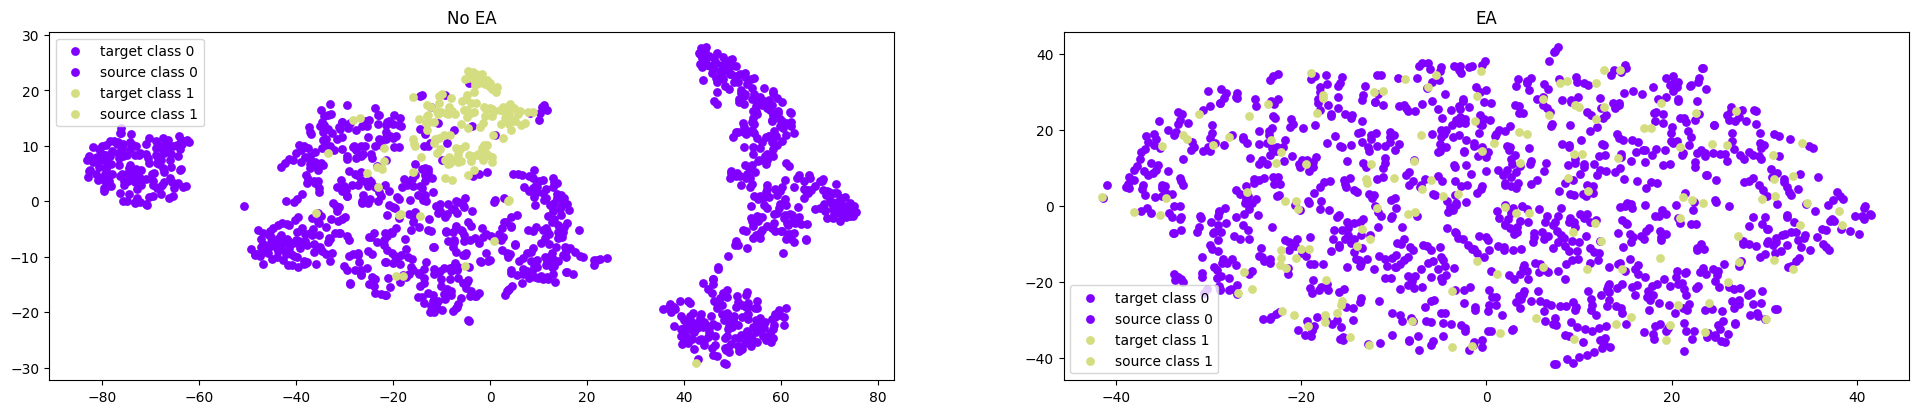

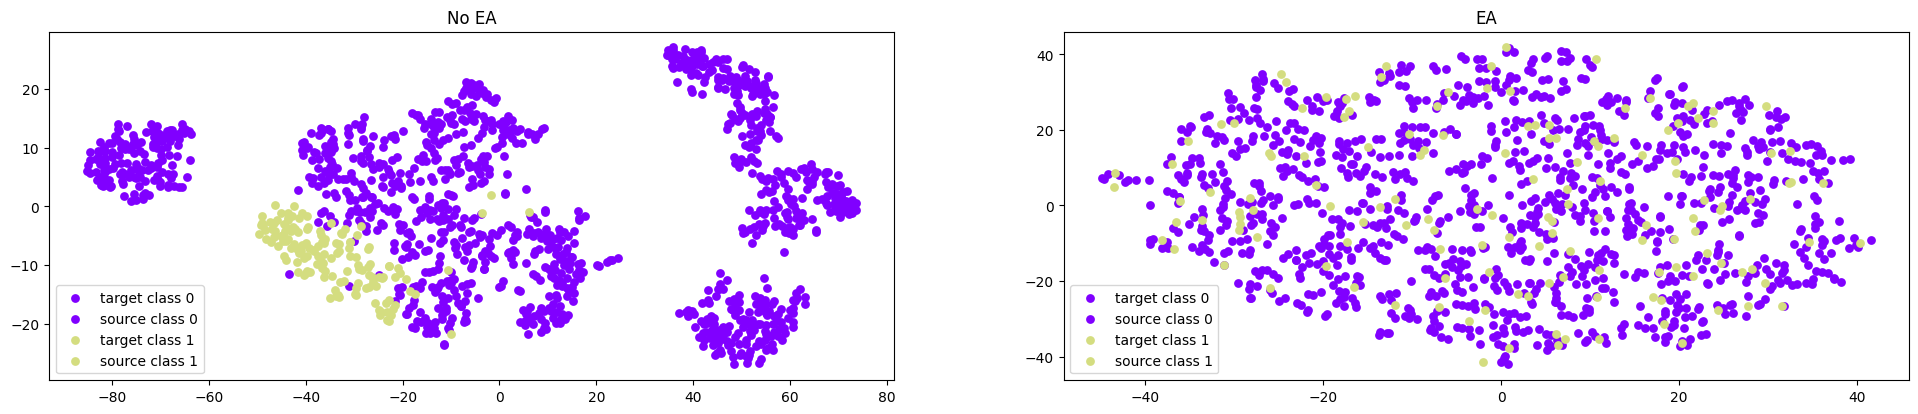

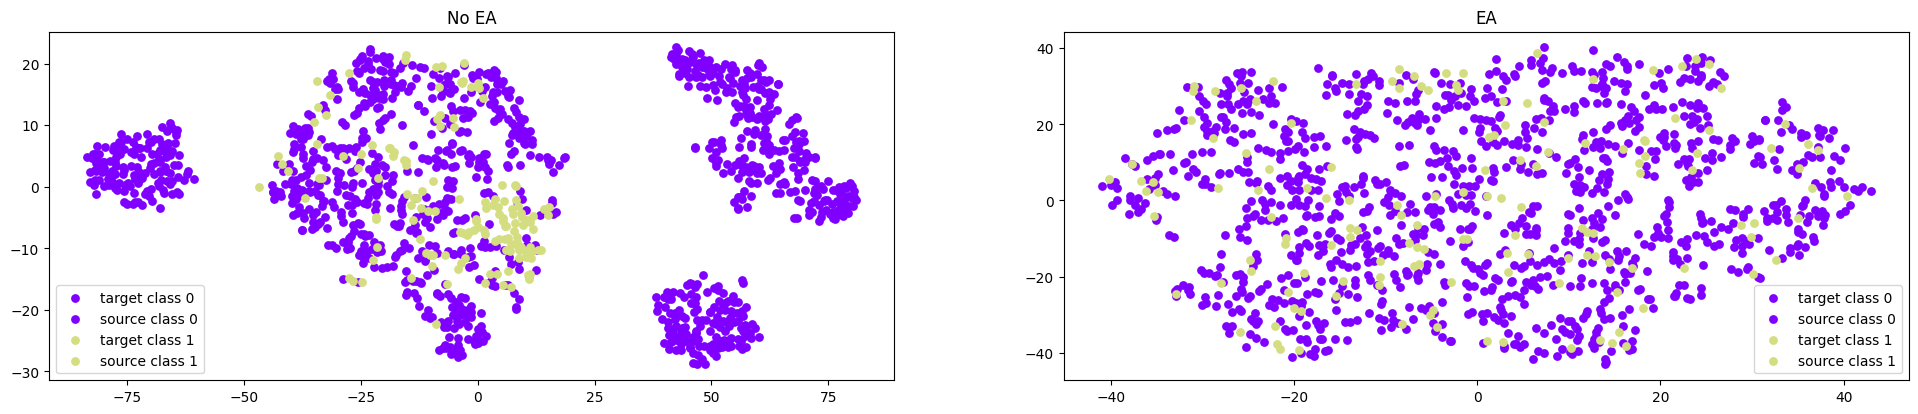

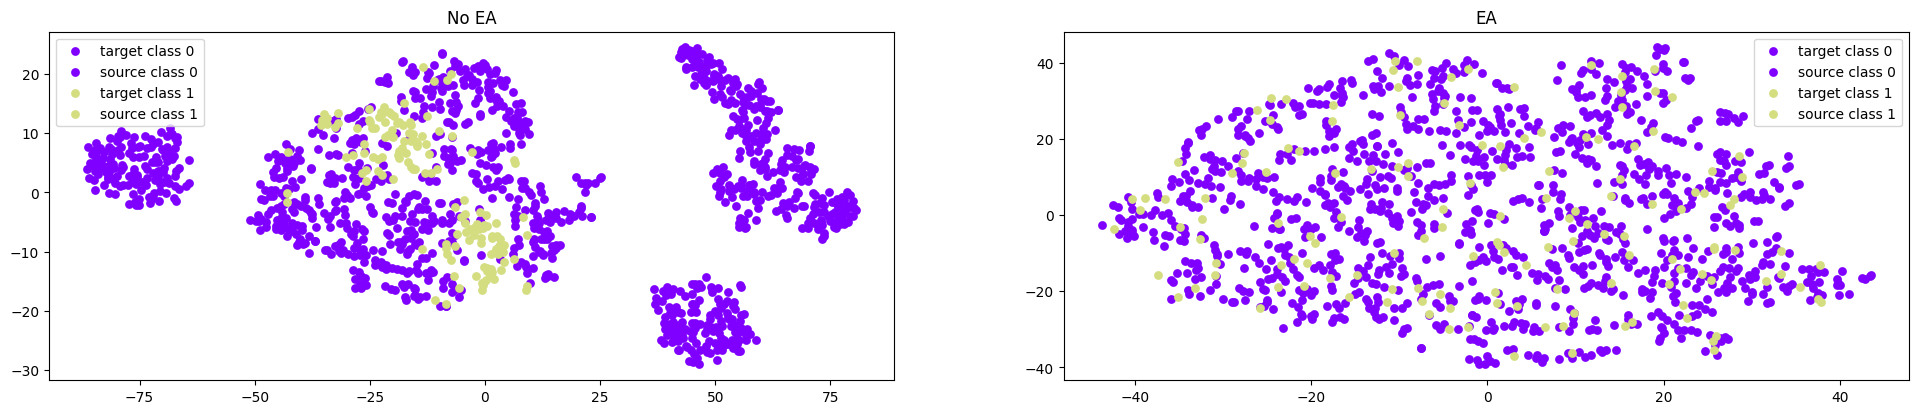

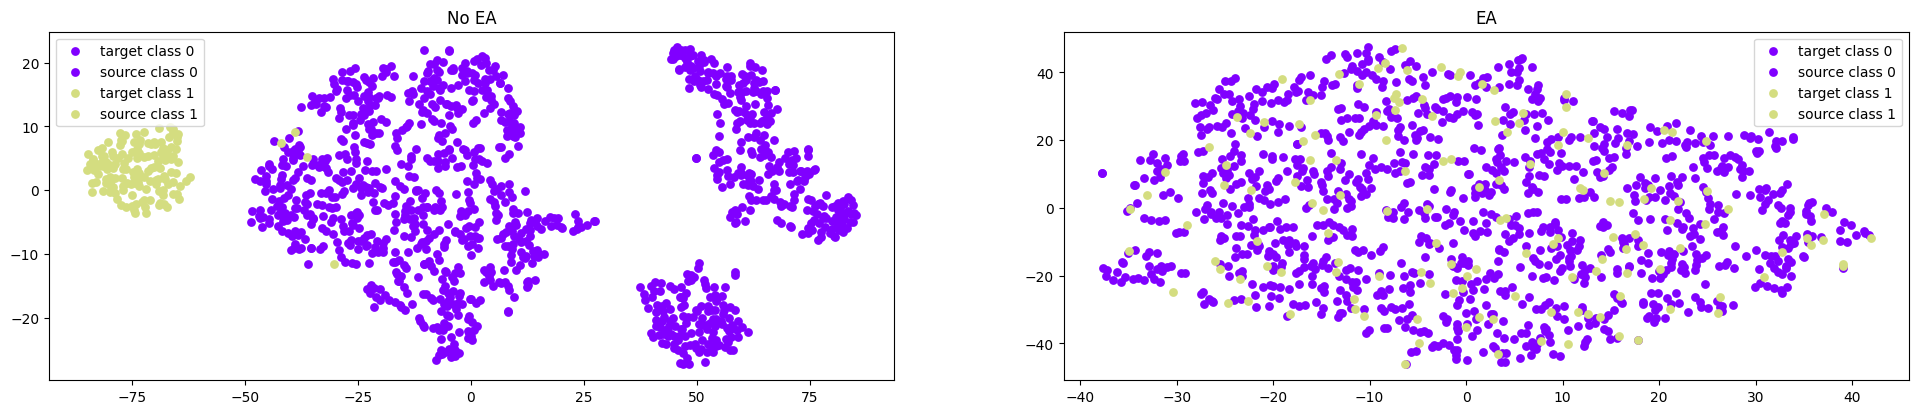

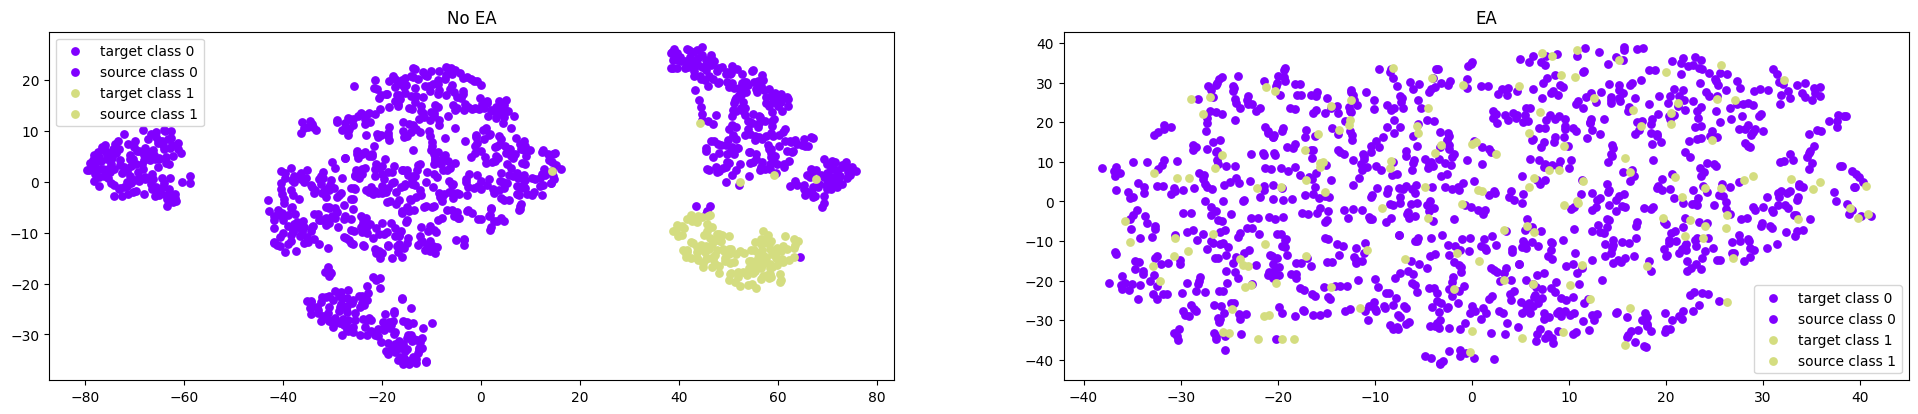

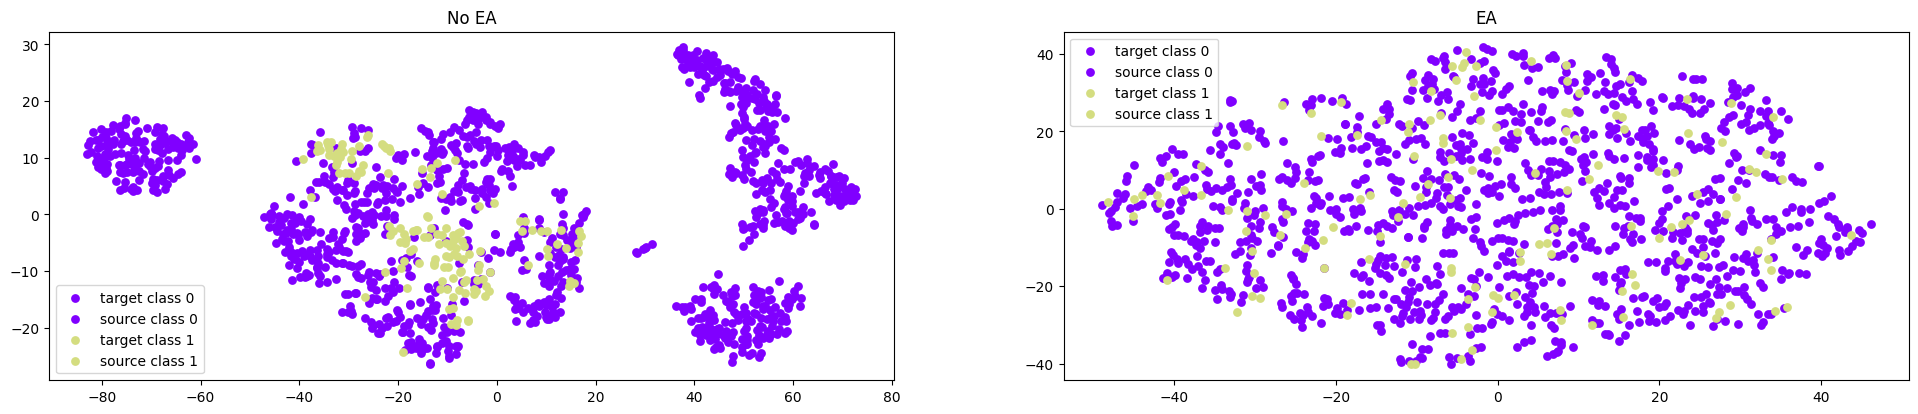

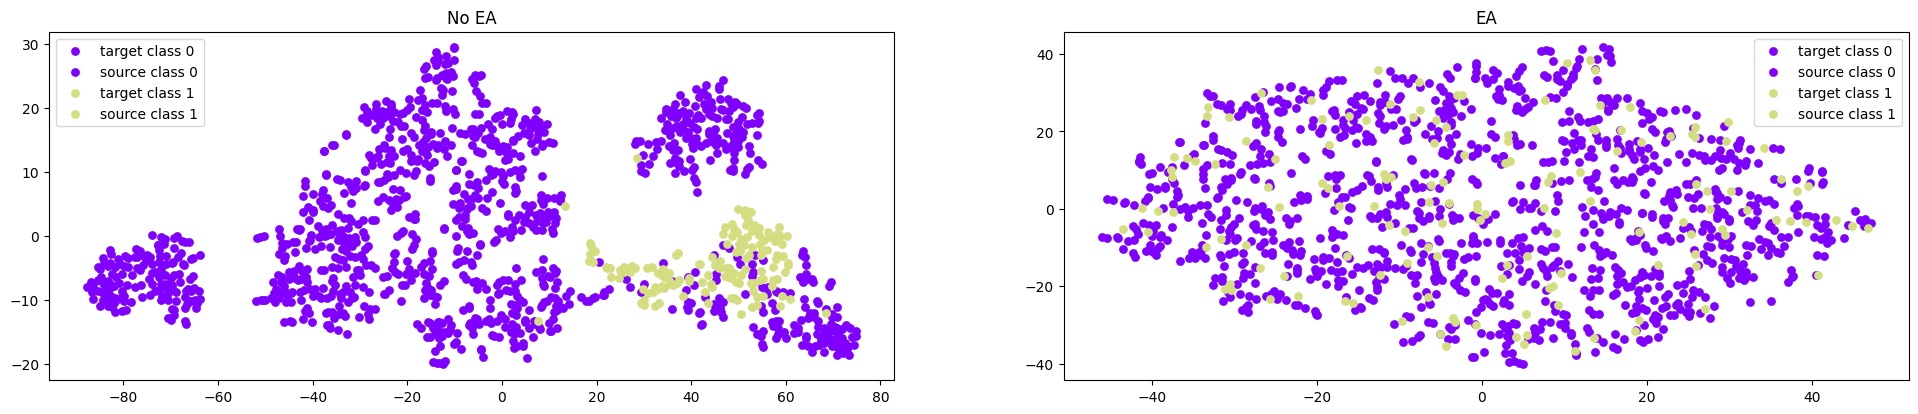

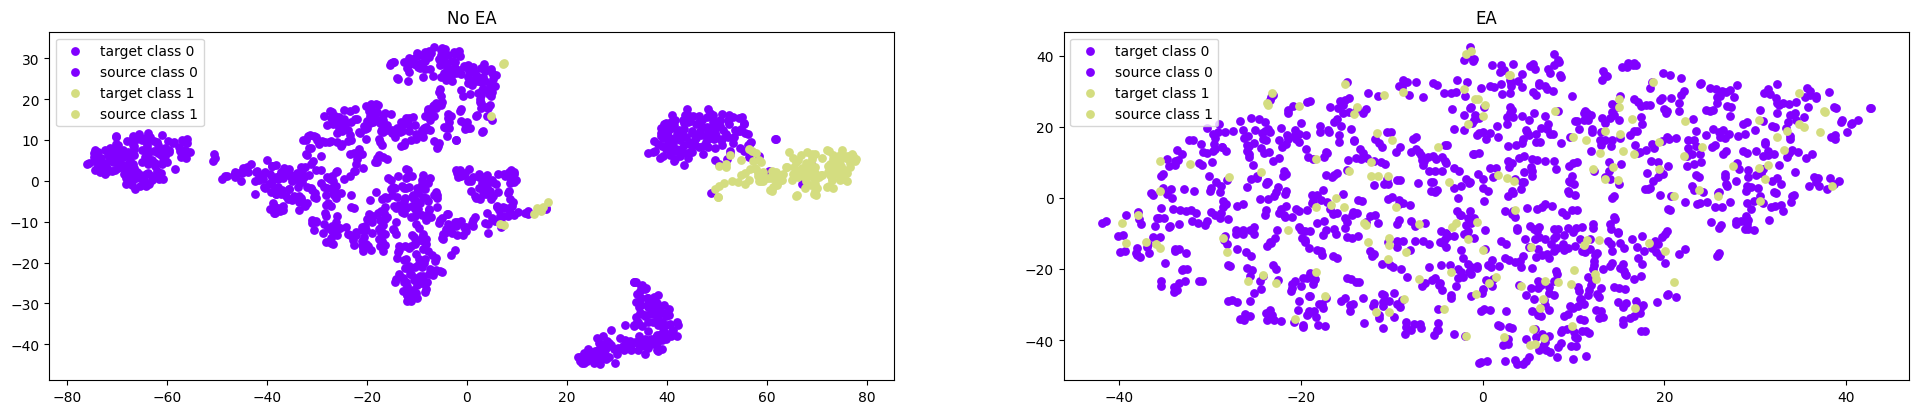

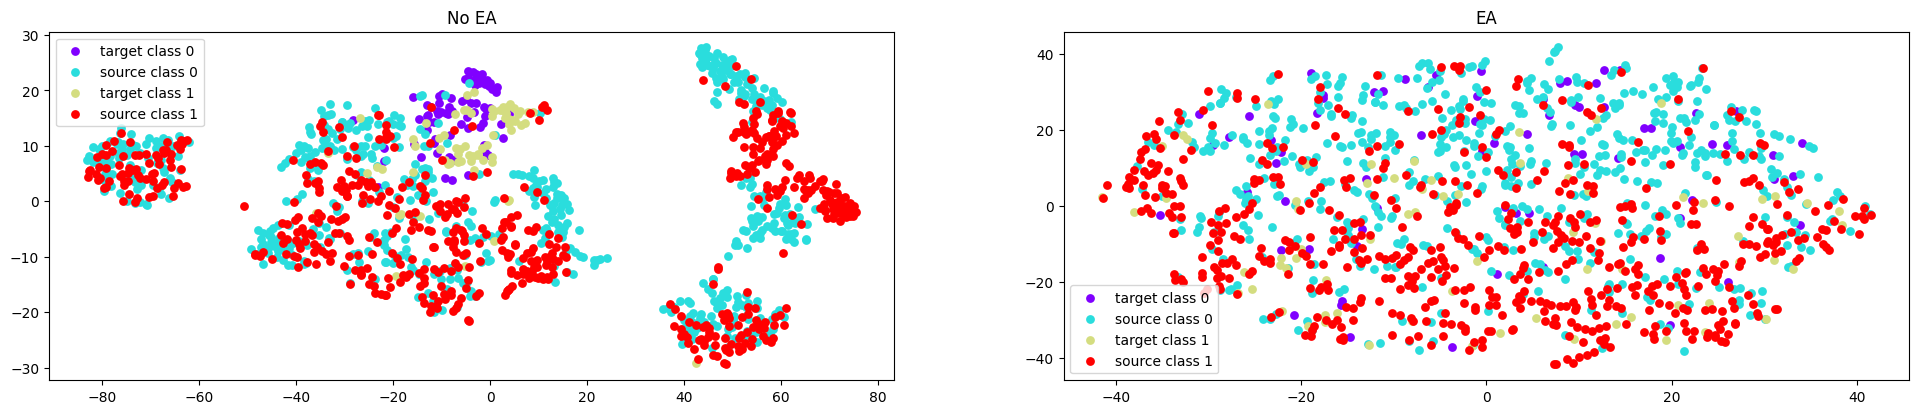

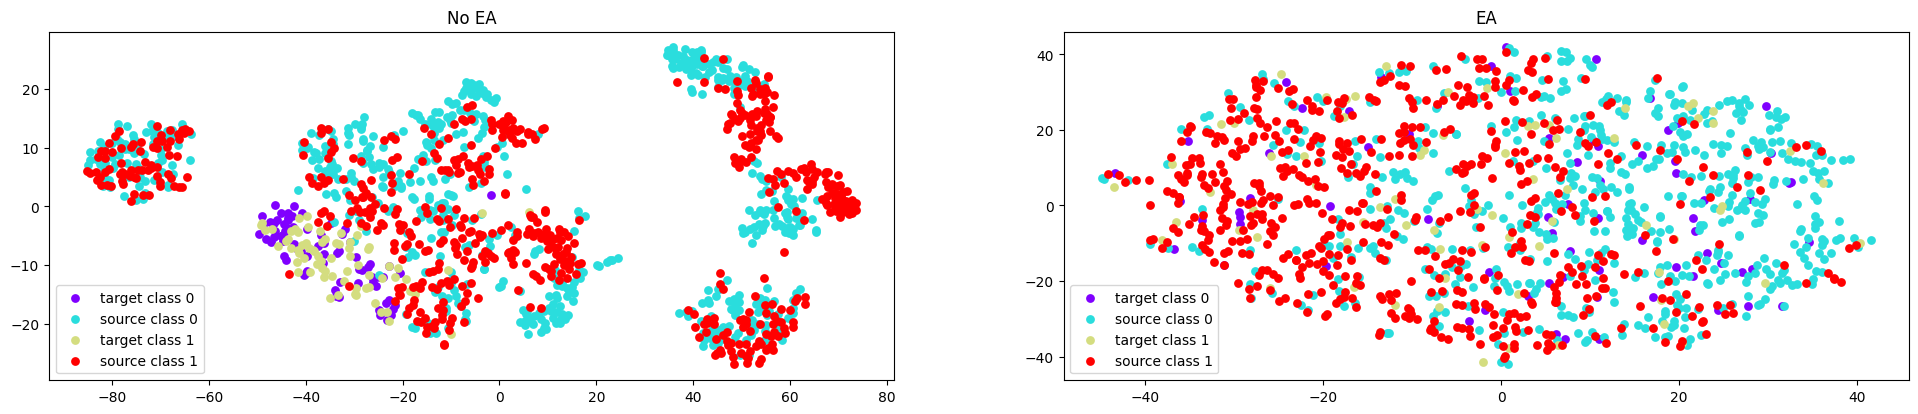

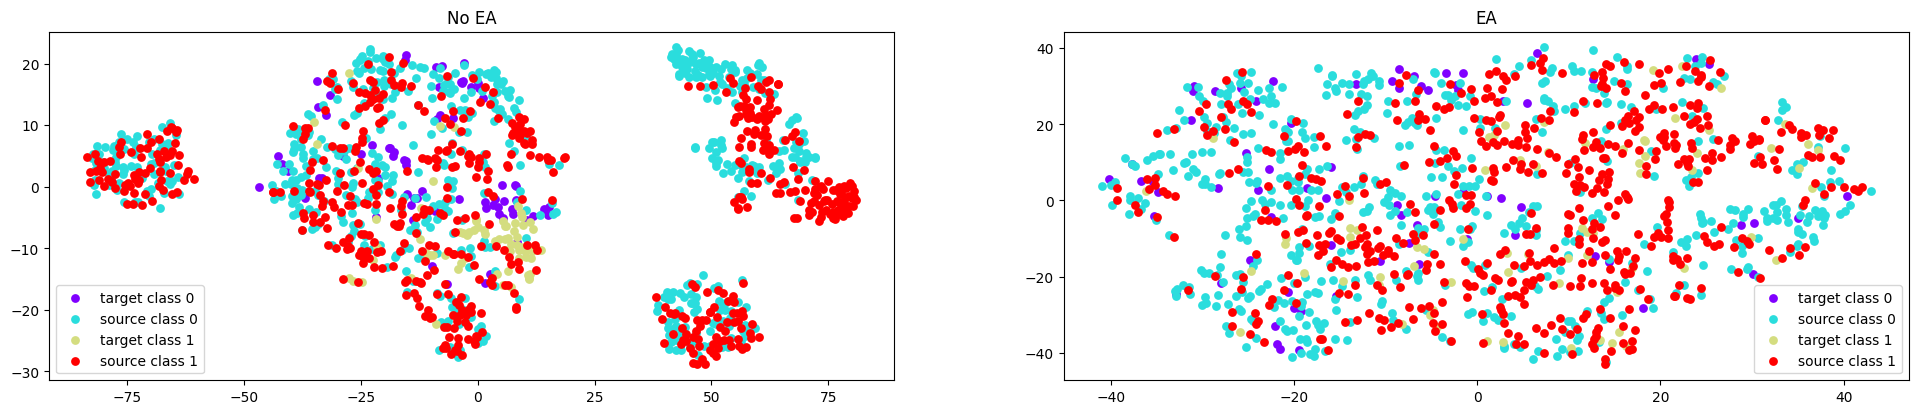

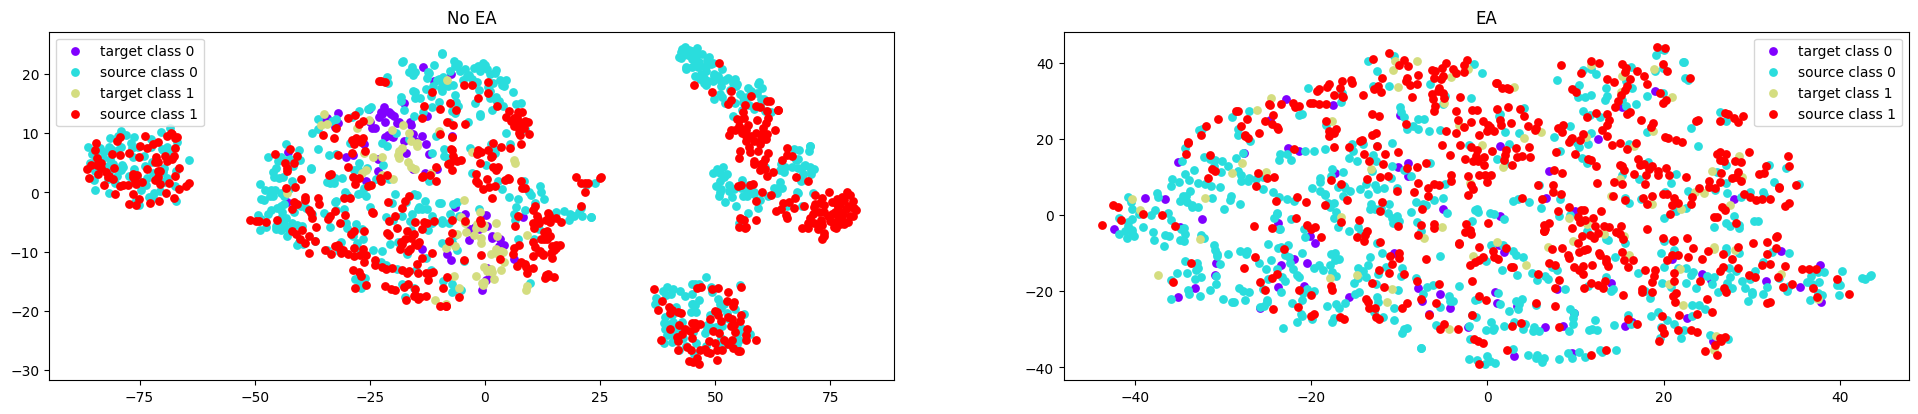

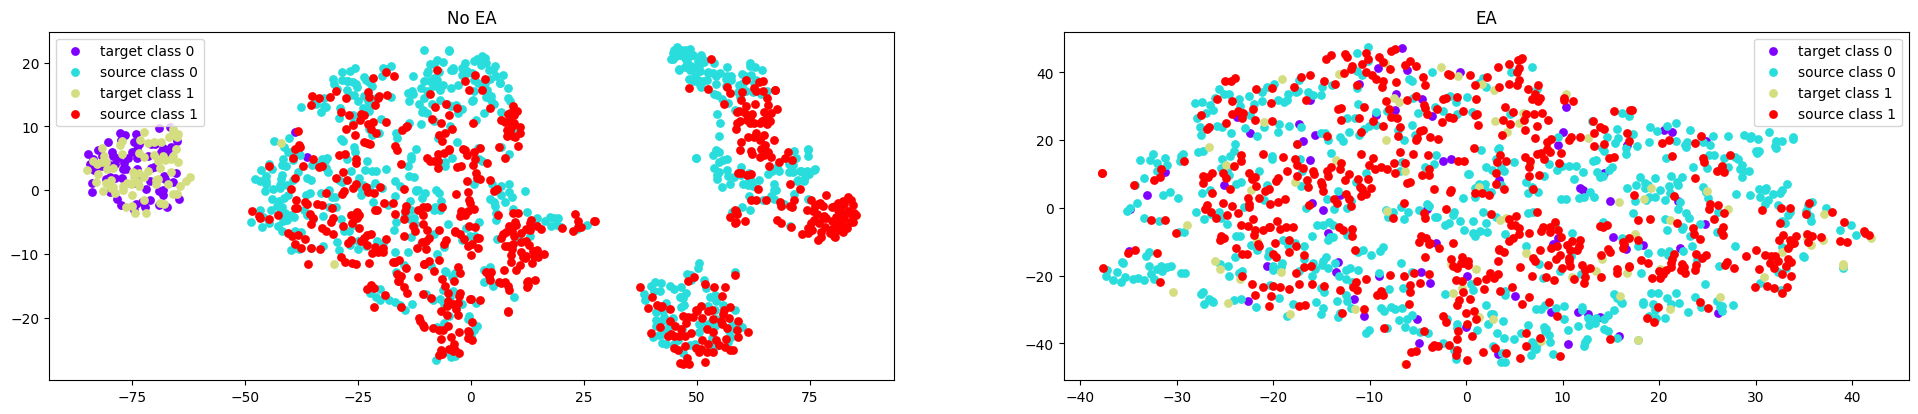

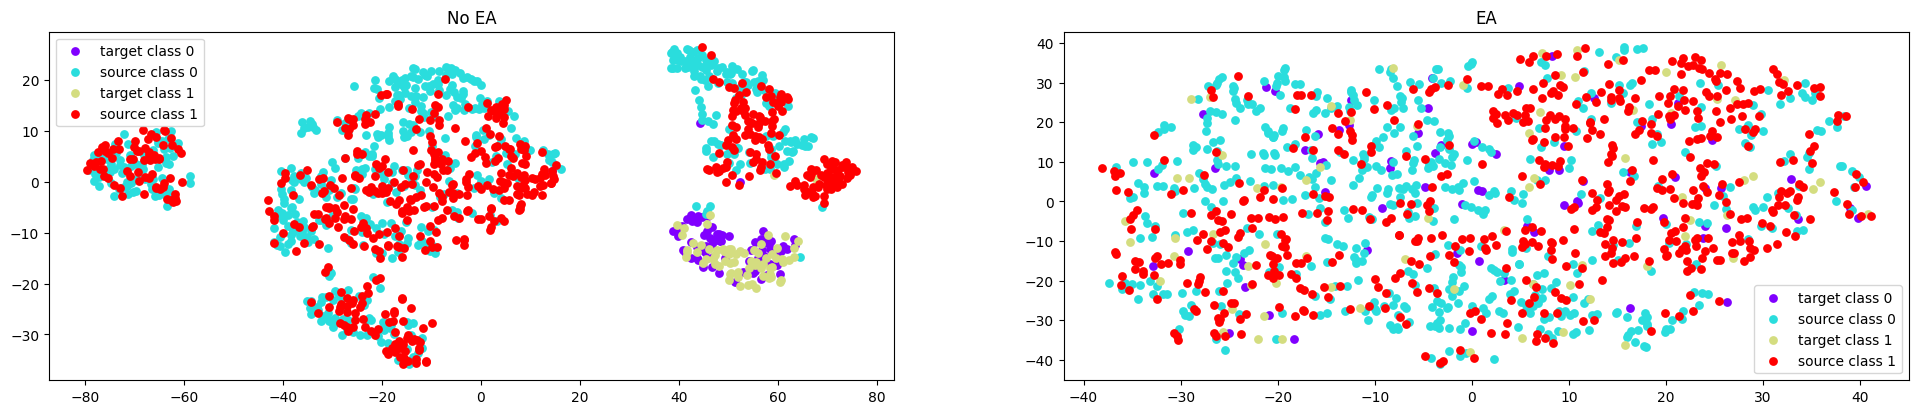

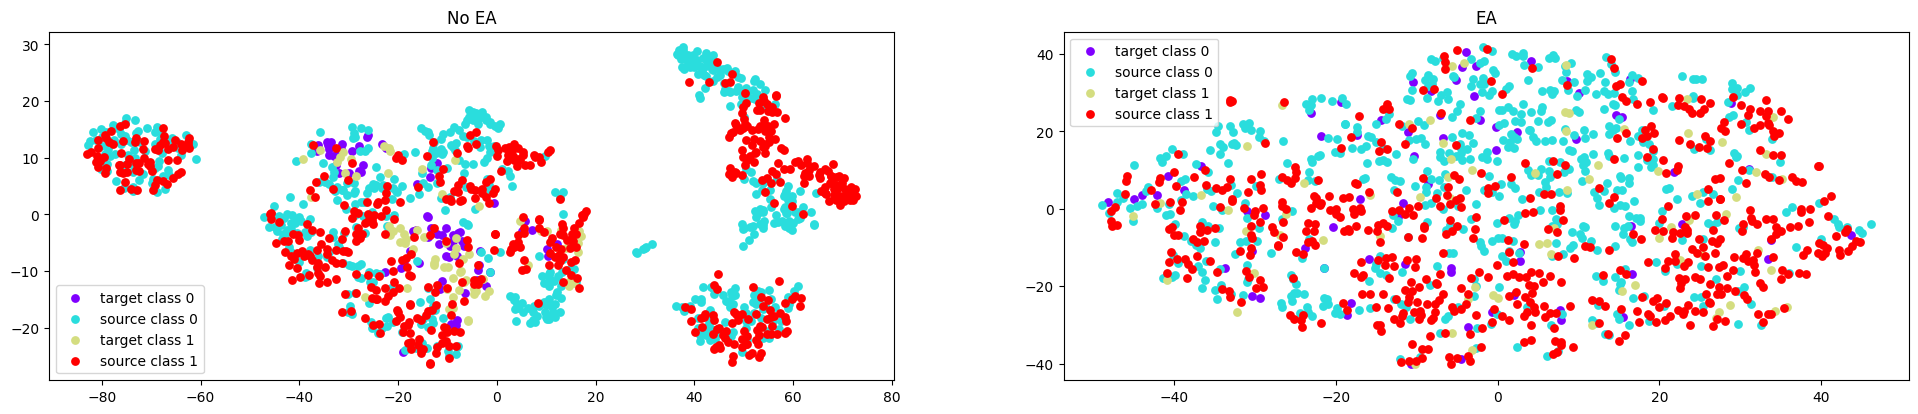

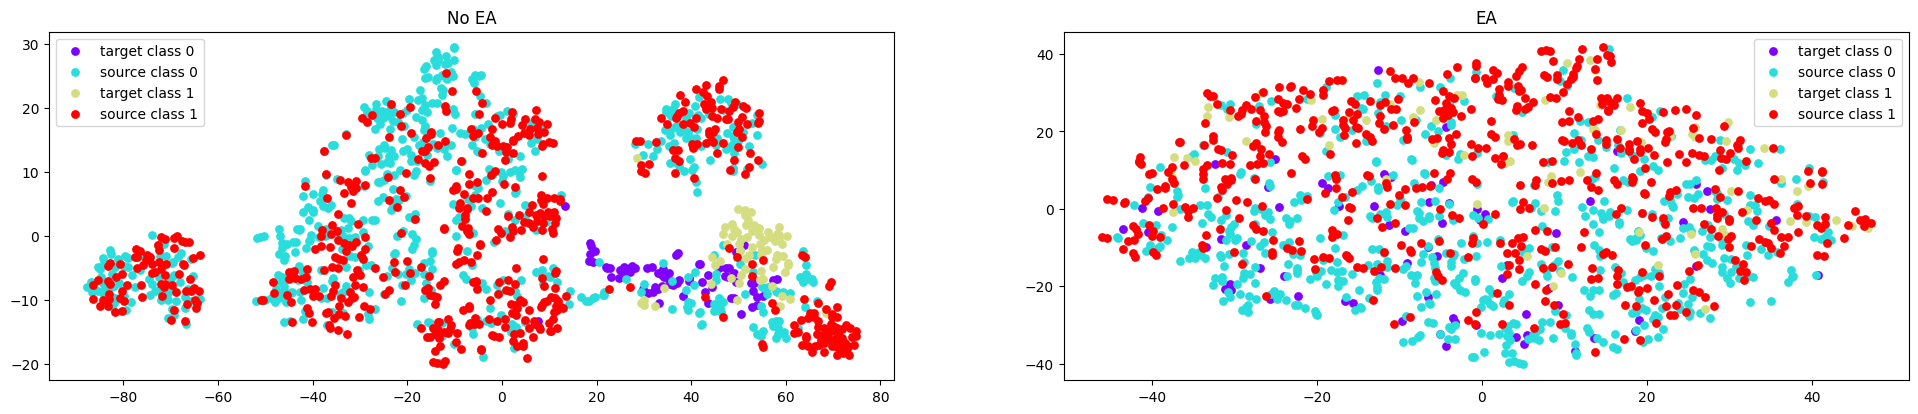

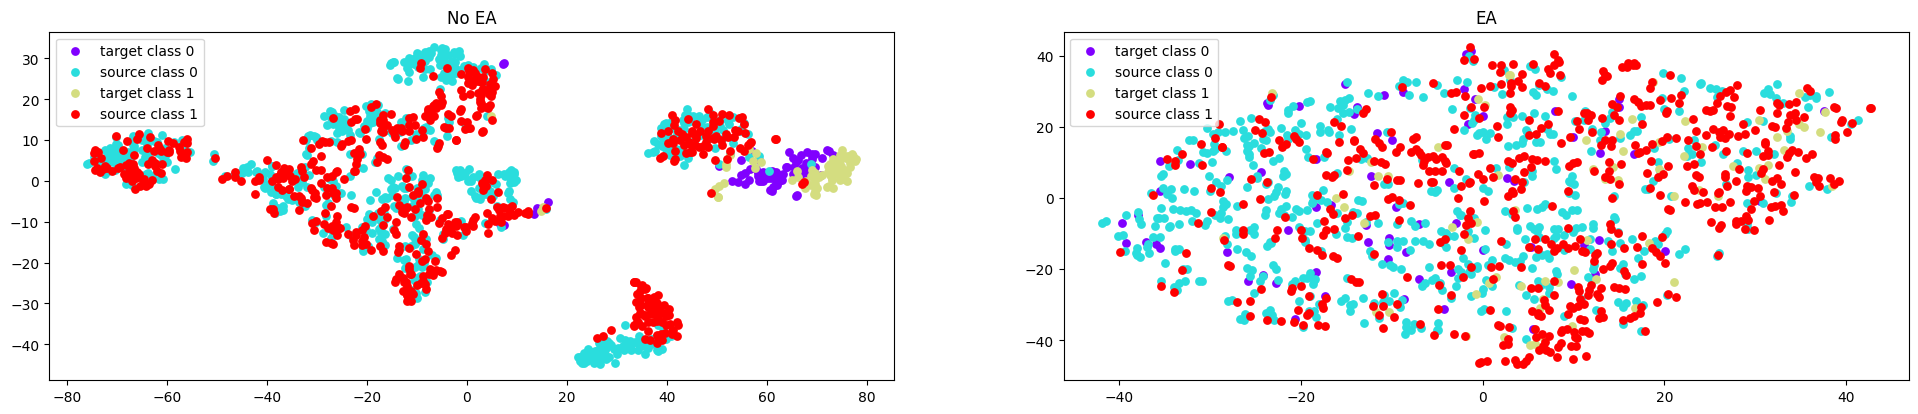

In [147]:
source_and_target_discrimination = np.zeros(y_tl.shape)
for s in range(y_tl.shape[0]):
  source_and_target_discrimination[s] = np.hstack((np.zeros(((ns - 1)*n_trials)), np.ones((n_trials)))).reshape(-1)

discrimination_labels = np.array([0, 1])

tl_plot_BCIIV2a('EA', t_sne, t_sne_double_EA, source_and_target_discrimination, discrimination_labels, ns, n_trials, 
                separate_source_and_target = False)



classes = np.unique(labels)
tl_plot_BCIIV2a('EA', t_sne, t_sne_double_EA, y_tl, classes, ns, n_trials)

## VAE Alignment

### Imports

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### MNIST*

#### Declaration

In [25]:
#MNIST For Warmup!

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))



class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        print(f'epoch: {epoch}, training loss: {loss}')
    return autoencoder


In [5]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

#### Training

In [15]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

epoch: 0, training loss: 4446.3076171875

epoch: 1, training loss: 3978.1015625

epoch: 2, training loss: 4114.50537109375

epoch: 3, training loss: 3970.903564453125

epoch: 4, training loss: 3746.56689453125

epoch: 5, training loss: 3775.61279296875

epoch: 6, training loss: 3708.762939453125

epoch: 7, training loss: 3672.67822265625

epoch: 8, training loss: 3690.8876953125

epoch: 9, training loss: 3831.869384765625

epoch: 10, training loss: 3603.1982421875

epoch: 11, training loss: 3606.412353515625

epoch: 12, training loss: 3769.04296875

epoch: 13, training loss: 3456.1337890625

epoch: 14, training loss: 3664.488037109375

epoch: 15, training loss: 3729.318603515625

epoch: 16, training loss: 3771.500244140625

epoch: 17, training loss: 3783.38134765625

epoch: 18, training loss: 3774.128662109375

epoch: 19, training loss: 3780.30517578125


#### Test

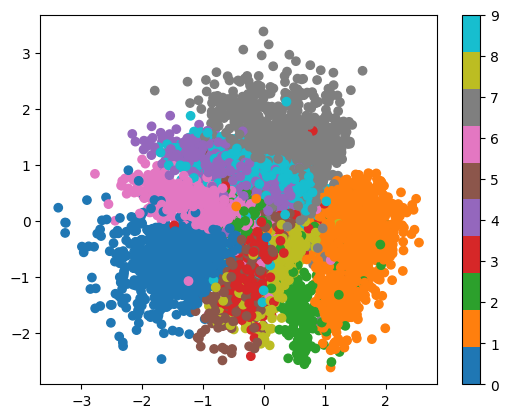

In [16]:
plot_latent(vae, data)

In [21]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

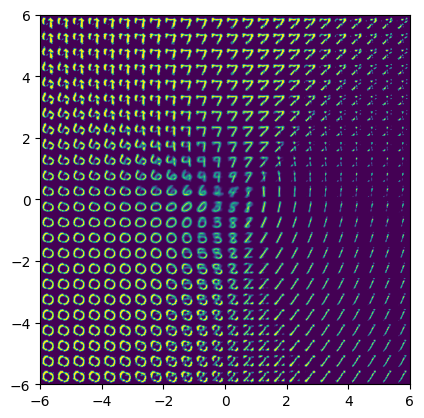

In [24]:
plot_reconstructed(vae, r0=(-6, 6), r1=(-6, 6))

### EEG

#### Declaration

In [100]:


class VariationalEncoder(nn.Module):
    def __init__(self, input_dims, latent_dims, permute = True):
        super(VariationalEncoder, self).__init__()
        self.permute = permute
        self.linear1 = nn.Linear(input_dims, latent_dims)
        self.linear2 = nn.Linear(latent_dims, latent_dims)
        self.linear3 = nn.Linear(latent_dims, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0


    def forward(self, x):
      if self.permute:
        x = torch.permute(x, (0, 2, 1))

      #Nonlinearity
      # x = F.relu(self.linear1(x))
      x = self.linear1(x)
      mu =  self.linear2(x)
      sigma = torch.exp(self.linear3(x))
      z = mu + sigma*self.N.sample(mu.shape)
      self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

      if self.permute:
        z = torch.permute(z, (0, 2, 1))
      return z


class Decoder(nn.Module):
    def __init__(self, output_dims, latent_dims, permute = True):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, output_dims)
        #Nonlinearity
        # self.linear2 = nn.Linear(512, 784)
        self.permute = permute

    def forward(self, z):
      if self.permute:
        z = torch.permute(z, (0, 2, 1))
      # z = F.relu(self.linear1(z))
      # z = torch.sigmoid(self.linear2(z))
      z = self.linear1(z)

      if self.permute:
        z = torch.permute(z, (0, 2, 1))
      return z



class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dims, latent_dims, permute = True):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dims, latent_dims, permute)
        self.decoder = Decoder(input_dims, latent_dims, permute)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def train(autoencoder, data, epochs=20, reconstruction_loss = True, reconstruction_loss_factor = 1, permute = True):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)

            loss = autoencoder.encoder.kl
            if (reconstruction_loss):
              loss += reconstruction_loss_factor*((x - x_hat)**2).sum()

            loss.backward()
            opt.step()
    print(f'epoch: {epoch}, training loss: {loss}')
    
    return autoencoder


#### Training (with reconstruction)

In [56]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor



batch_size = 48
vae_aligned_reconstruction_data = np.zeros(data.shape)

for s in range(ns):
  data_vae = TensorDataset(Tensor(data[s]).to(device), Tensor(labels[s]).to(device))
  dataloader = torch.utils.data.DataLoader(data_vae,
          batch_size=batch_size,
          shuffle=True)

  # vae = VariationalAutoencoder(n_channels, n_channels).to(device) # GPU
  vae = train(vae, dataloader, epochs = 30, reconstruction_loss_factor = 5)

  vae_aligned_reconstruction_data[s] = vae.decoder(Tensor(data[s]).to(device)).cpu().detach().numpy()

epoch: 29, training loss: 2201517.75

epoch: 29, training loss: 2165944.0

epoch: 29, training loss: 2375977.25

epoch: 29, training loss: 2121507.5

epoch: 29, training loss: 1973988.0

epoch: 29, training loss: 2760989.5

epoch: 29, training loss: 2120178.75

epoch: 29, training loss: 2921773.0

epoch: 29, training loss: 3111770.25


#### CSP feature extraction on VAE aligned data (with reconstruction)

In [ ]:
!pip install mne

In [57]:
from mne.decoding import CSP

components = 6

csp_features_vae_aligned_reconstruction = np.zeros((ns, n_trials*ns, components))
subjects = np.arange(ns)
y_tl = np.zeros((ns, n_trials*ns))


# The last 144 trials belong to the target subject

for i in range(ns):

  x_src_aligned = np.reshape(vae_aligned_reconstruction_data[subjects != i, :, :], (n_trials*(ns-1), n_channels , n_samples))
  x_tgt_aligned = np.reshape(vae_aligned_reconstruction_data[subjects == i, :, :], (n_trials, n_channels , n_samples))

  y_src = np.reshape(labels[subjects != i], (n_trials*(ns-1)))
  y_tgt = np.reshape(labels[subjects == i], (n_trials))

  csp = CSP(n_components = components, log = None, norm_trace = True)

  x_src_aligned = csp.fit_transform(x_src_aligned, y_src)
  x_tgt_aligned = csp.transform(x_tgt_aligned)

  csp_features_vae_aligned_reconstruction[i, :, :] = np.vstack((x_src_aligned, x_tgt_aligned))
  y_tl[i,:] = np.hstack((y_src, y_tgt)).reshape((-1))



Computing rank from data with rank=None

    Using tolerance 3.2e+02 (2.2e-16 eps * 22 dim * 6.7e+16  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 3.3e+02 (2.2e-16 eps * 22 dim * 6.7e+16  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 3.2e+02 (2.2e-16 eps * 22 dim * 6.6e+16  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 3.3e+02 (2.2e-16 eps * 22 dim * 6.7e+16

### Training with reconstruction and EA

In [83]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor



batch_size = 48
vae_aligned_reconstruction_data_EA = np.zeros(data.shape)
vae = VariationalAutoencoder(n_channels, n_channels).to(device) # GPU

for s in range(ns):
  data_vae = TensorDataset(Tensor(EA_aligned_data[s]).to(device), Tensor(labels[s]).to(device))
  dataloader = torch.utils.data.DataLoader(data_vae,
          batch_size=batch_size,
          shuffle=True)

  # vae = VariationalAutoencoder(n_channels, n_channels).to(device) # GPU
  vae = train(vae, dataloader, epochs = 30, reconstruction_loss_factor = 5)

  vae_aligned_reconstruction_data_EA[s] = vae.decoder(Tensor(data[s]).to(device)).cpu().detach().numpy()

epoch: 29, training loss: 301571.0625

epoch: 29, training loss: 302073.65625

epoch: 29, training loss: 302549.90625

epoch: 29, training loss: 301518.78125

epoch: 29, training loss: 302174.6875

epoch: 29, training loss: 302168.6875

epoch: 29, training loss: 301805.71875

epoch: 29, training loss: 300840.21875

epoch: 29, training loss: 301302.125


#### TSNE Visualization for VAE aligned (with reconstruction)

In [27]:
from sklearn.manifold import TSNE


t_sne = np.zeros((ns, ns*n_trials, 2))
t_sne_vae_aligned_reconstruction = np.zeros((ns, ns*n_trials, 2))

for subject in range(ns):
    t_sne[subject] = TSNE(n_iter=2000).fit_transform(csp_features[subject])
    t_sne_vae_aligned_reconstruction[subject] = TSNE(n_iter=2000).fit_transform(csp_features_vae_aligned_reconstruction[subject])


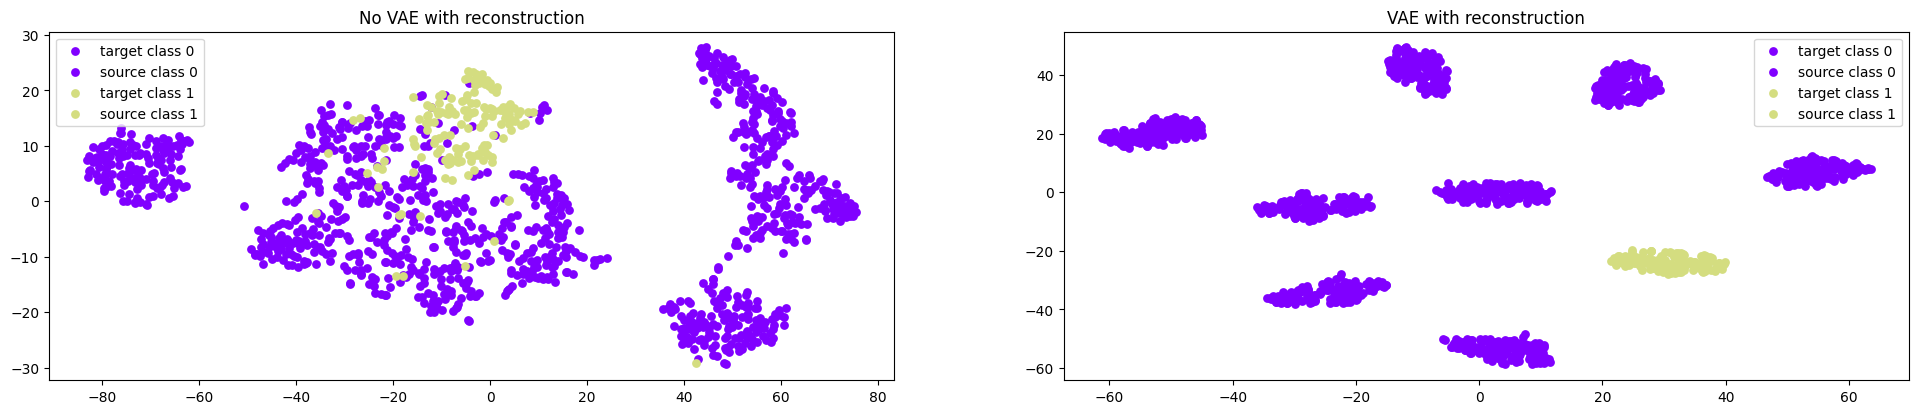

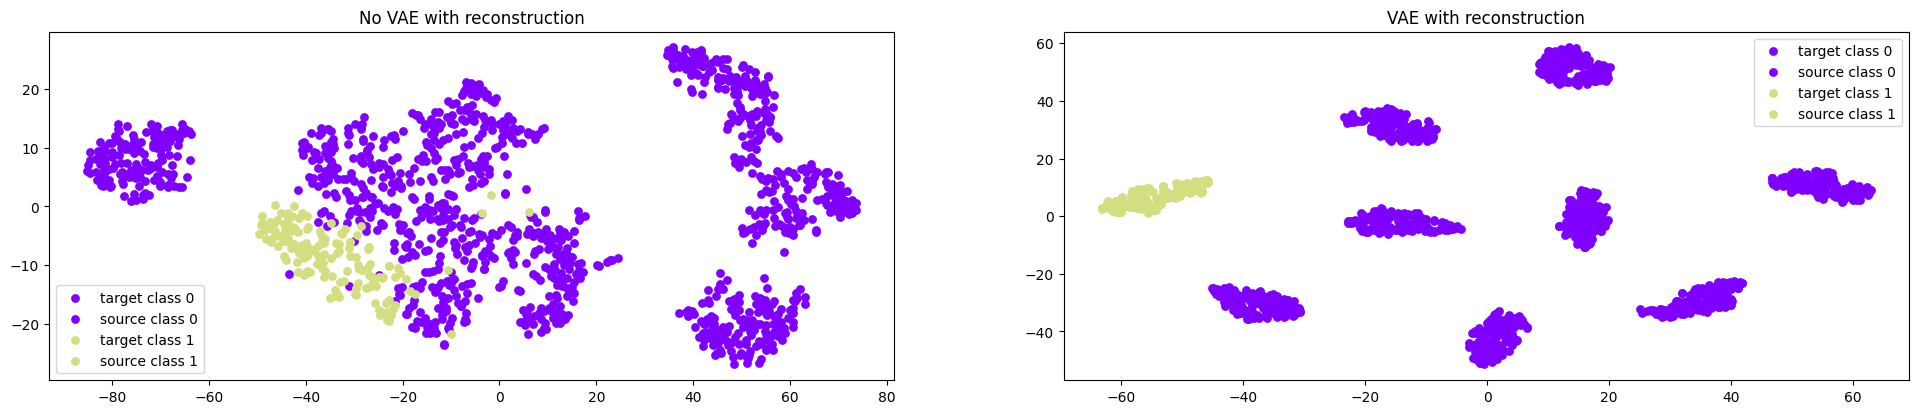

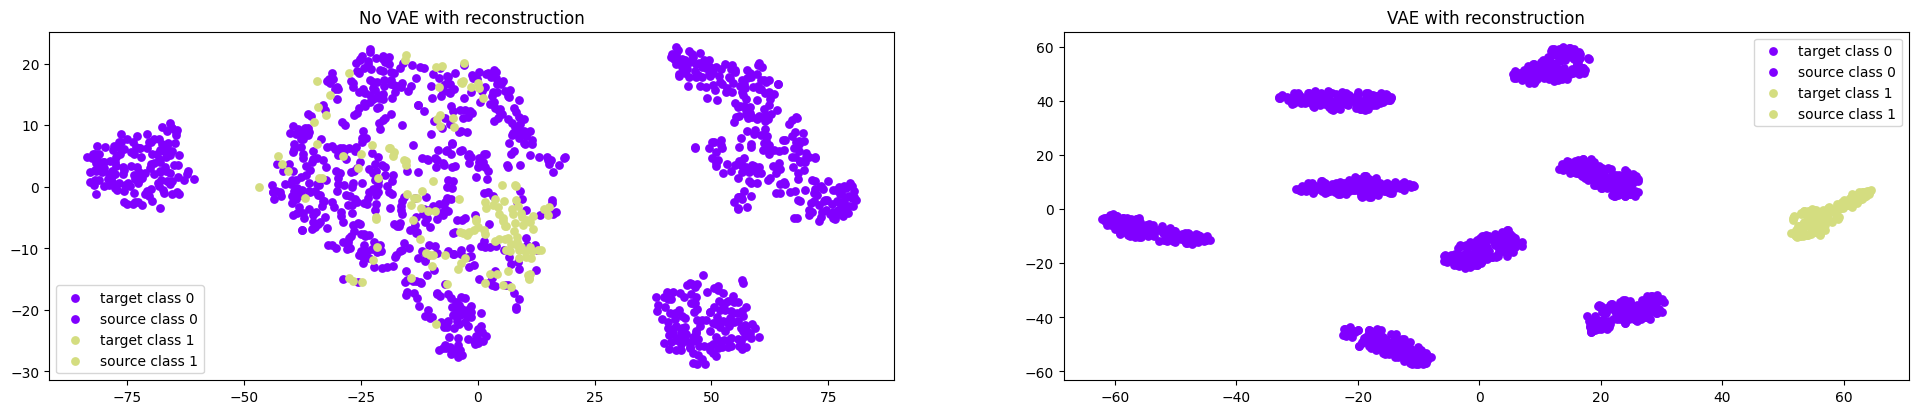

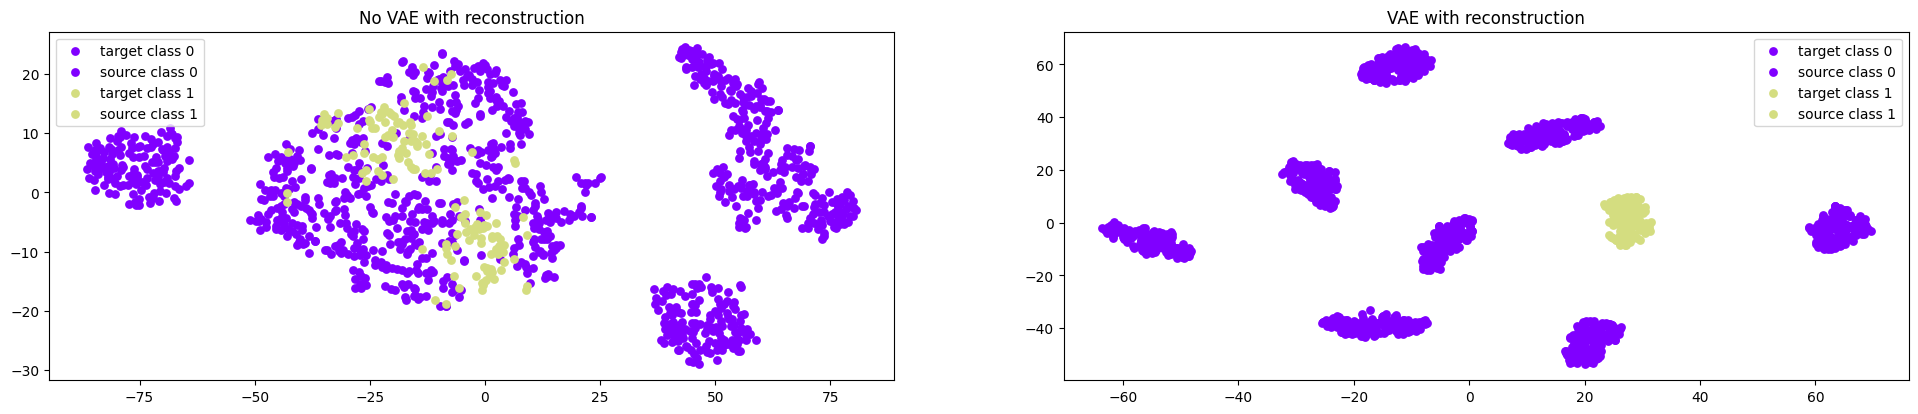

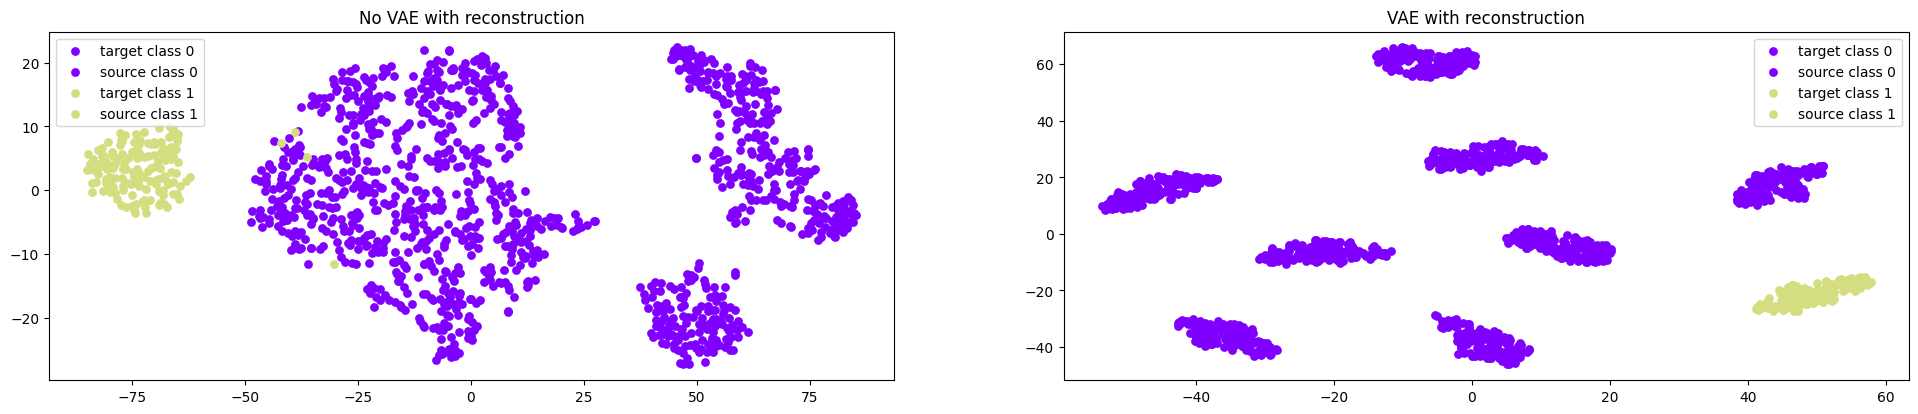

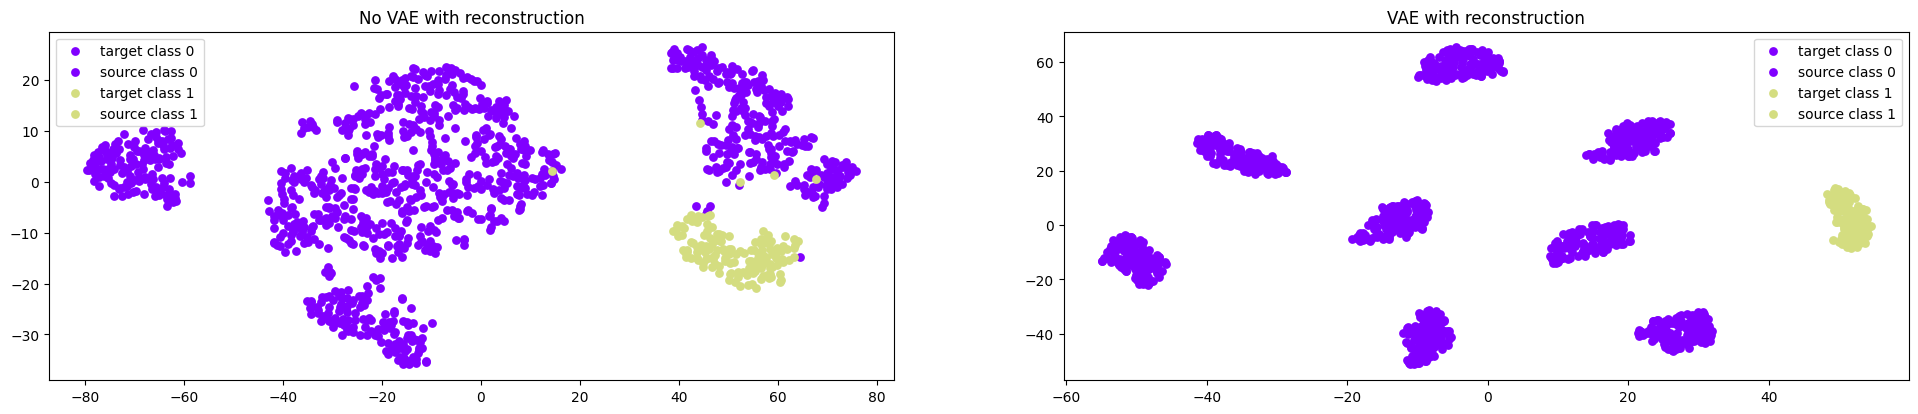

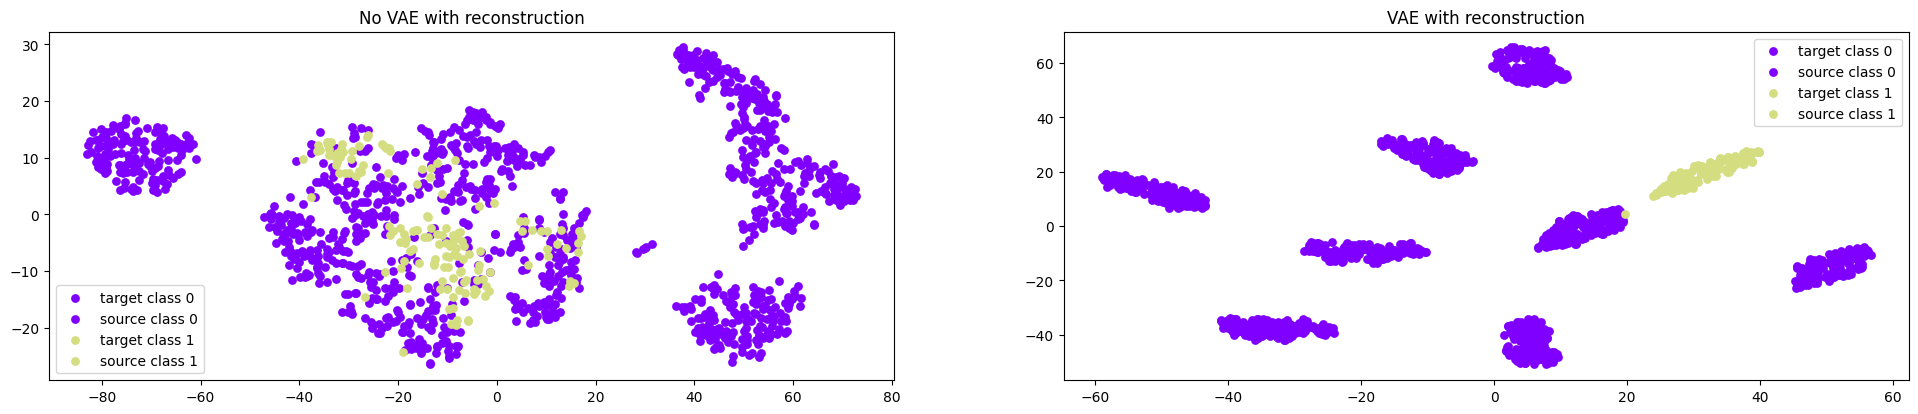

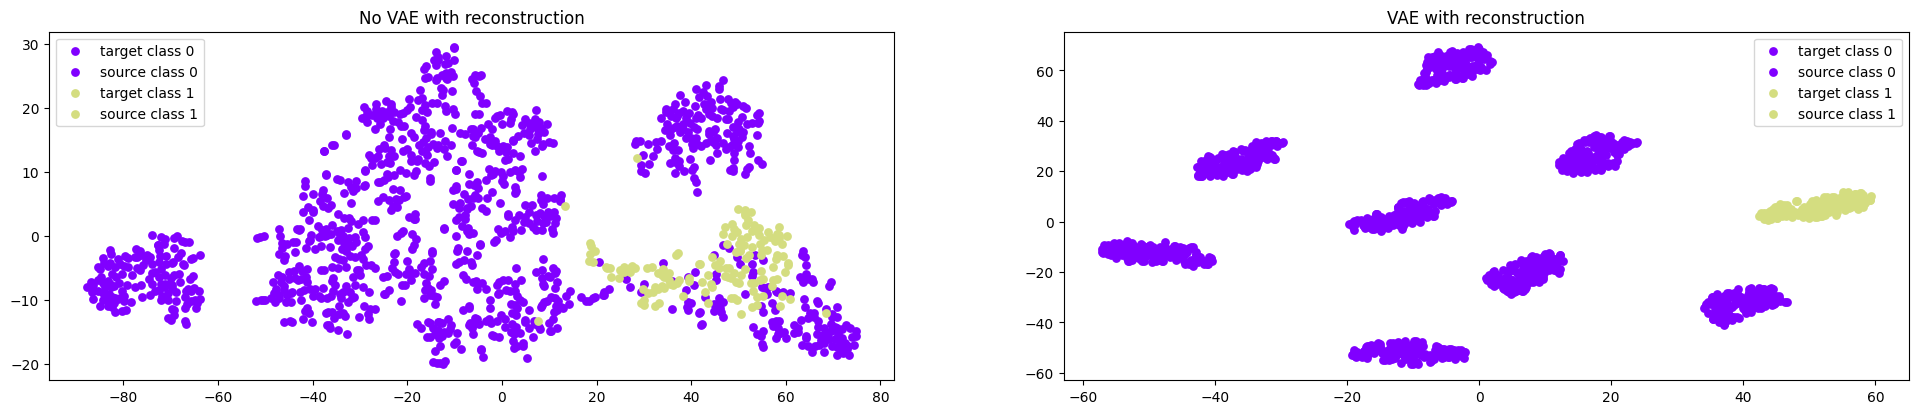

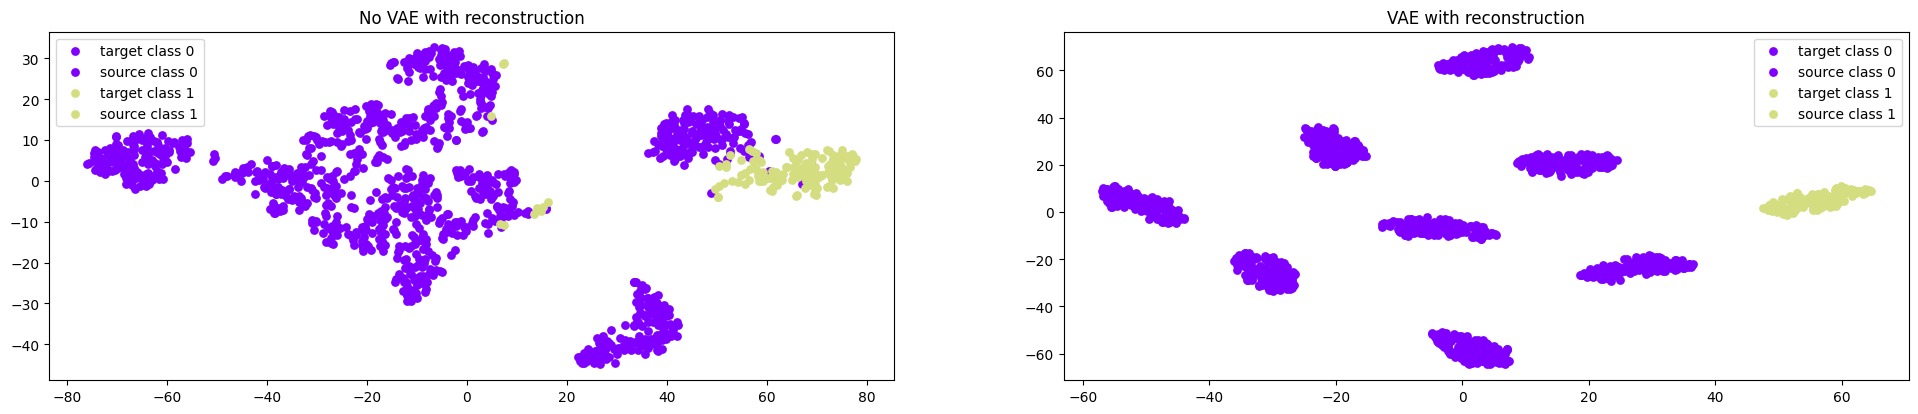

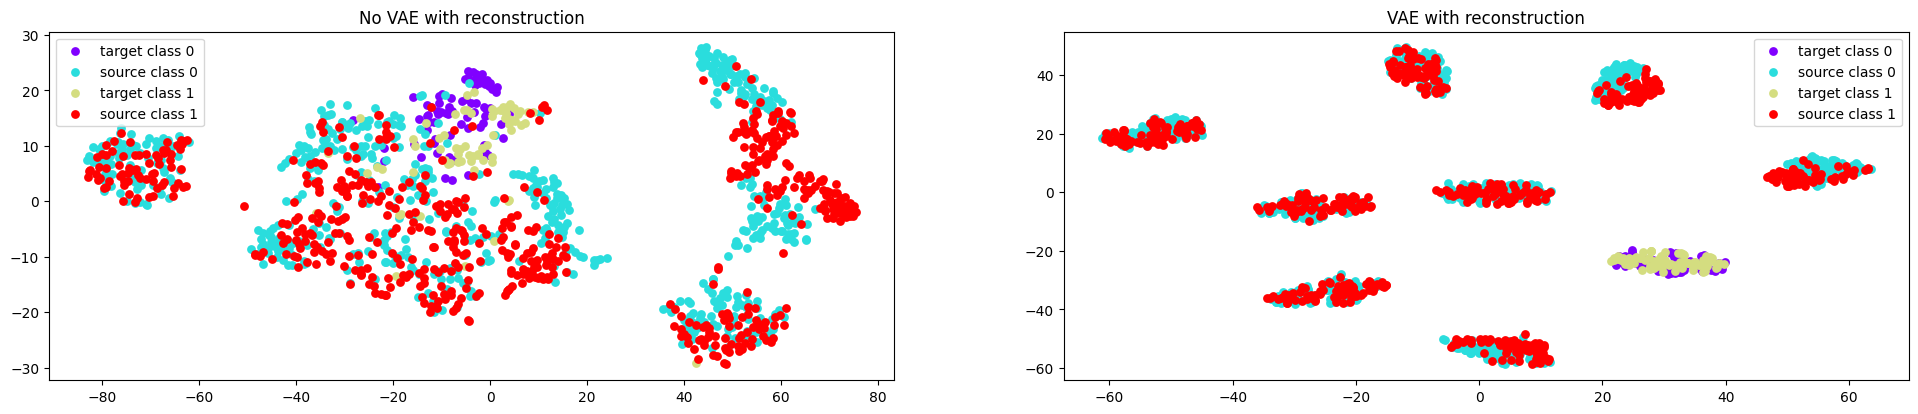

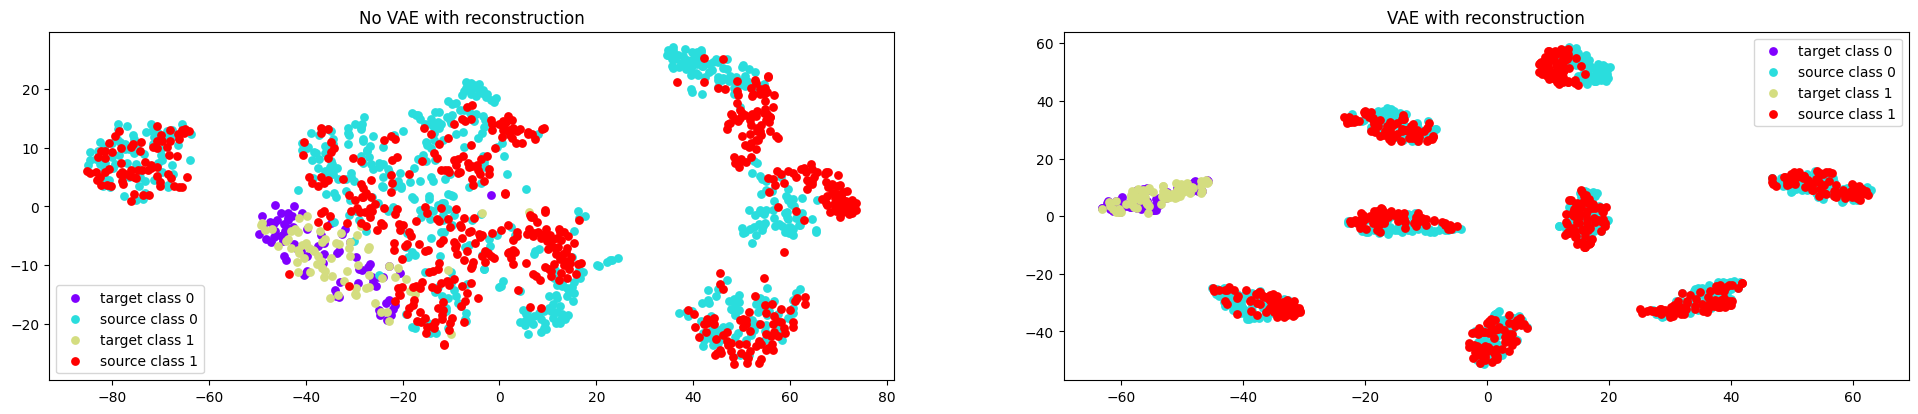

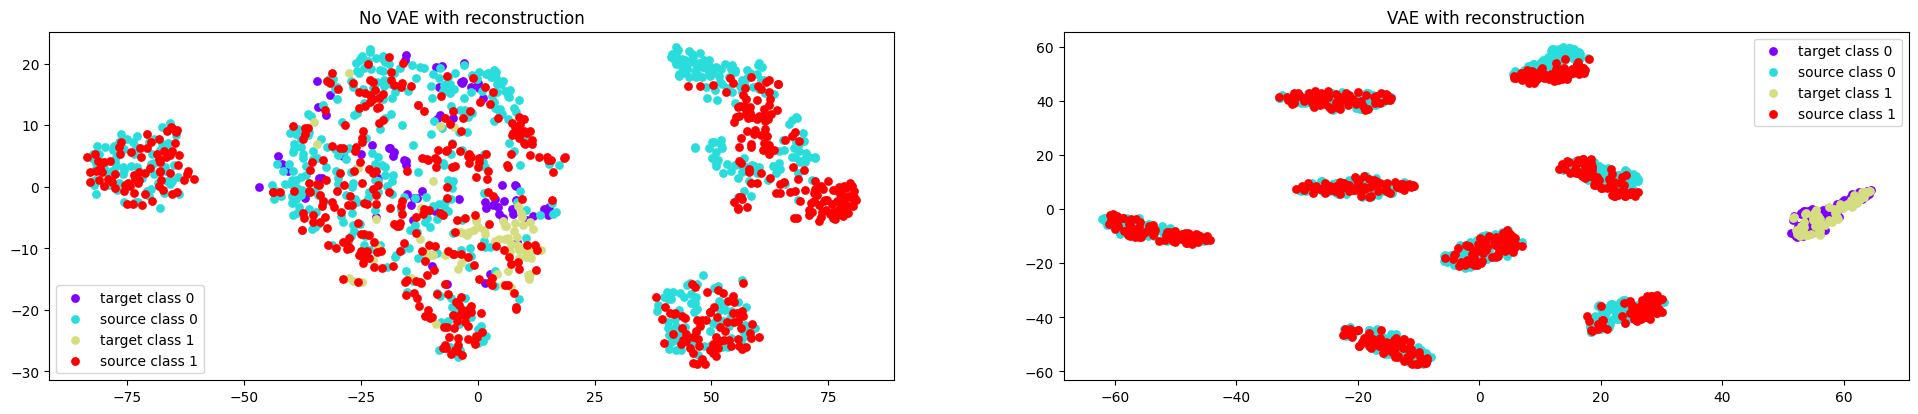

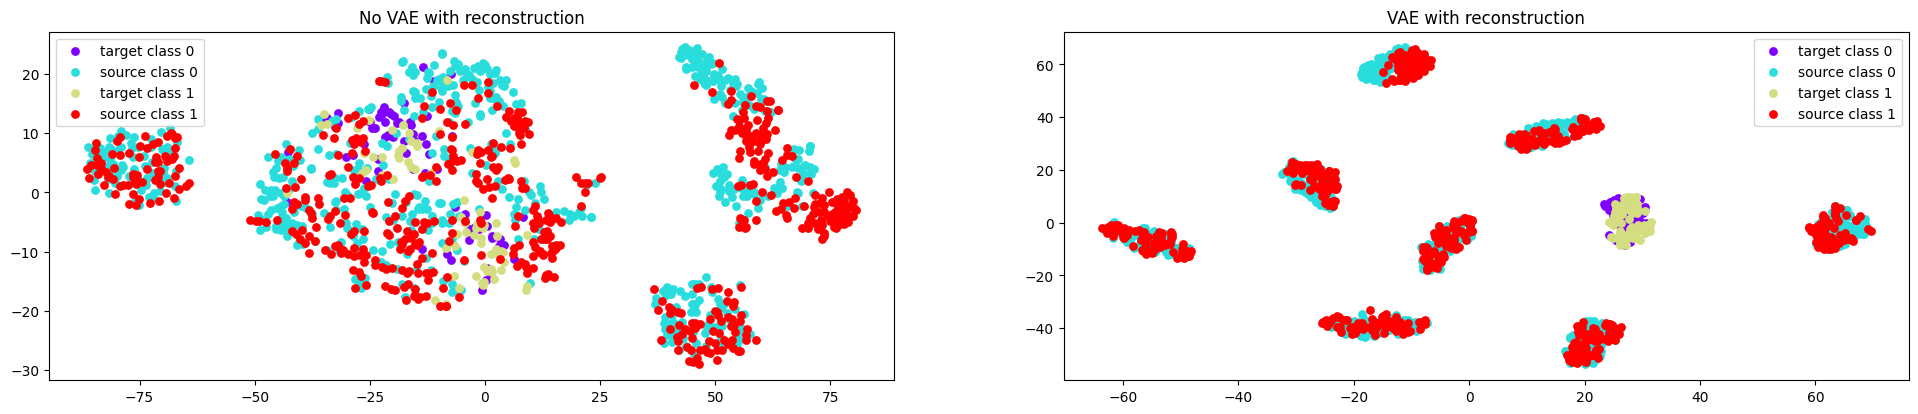

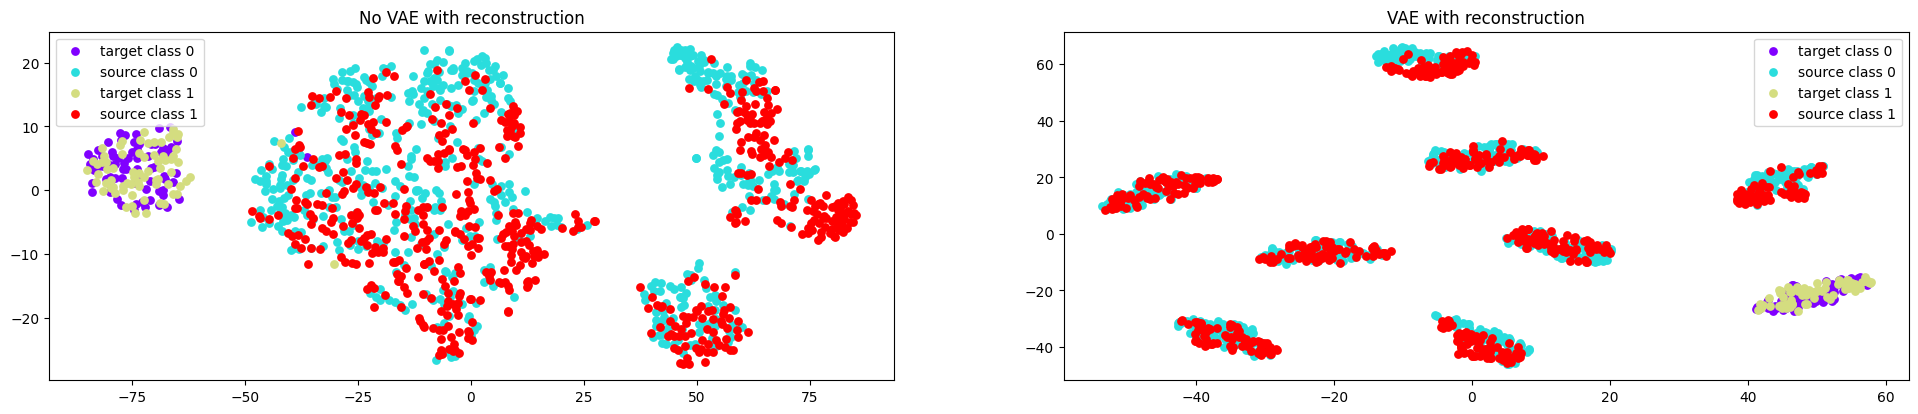

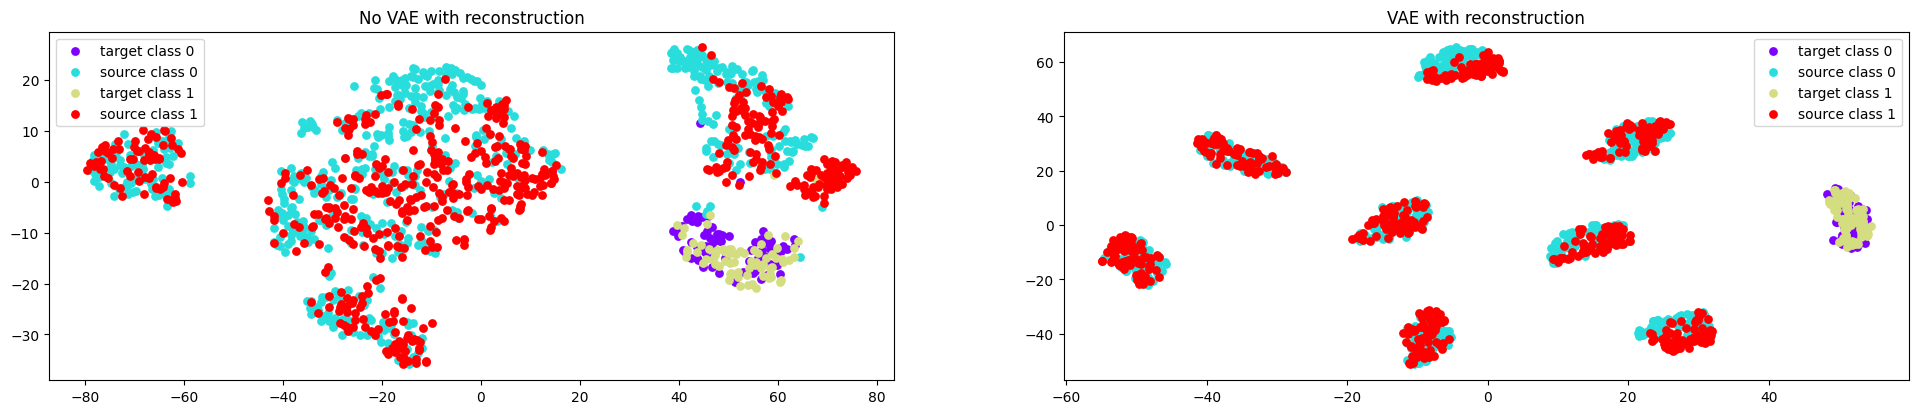

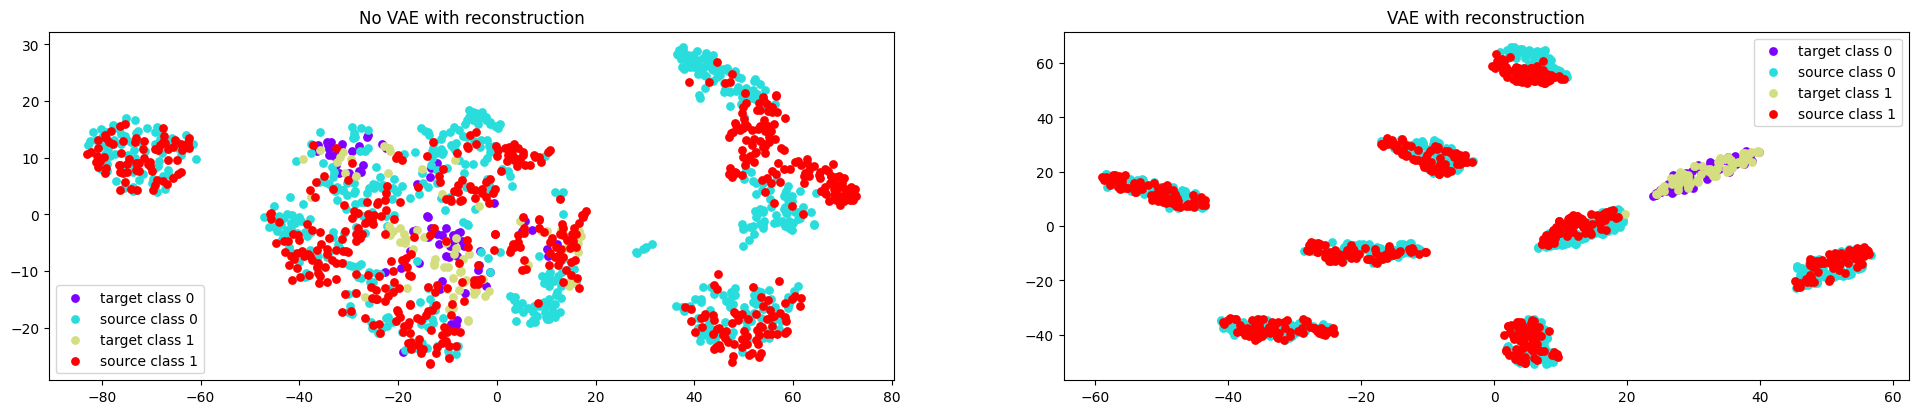

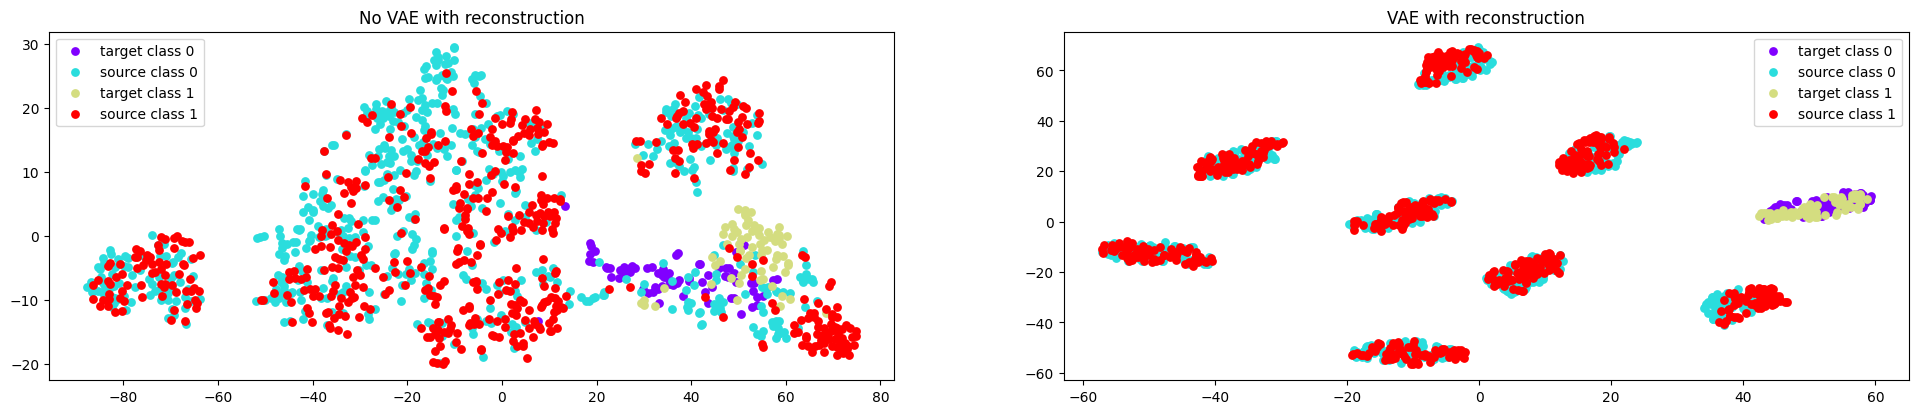

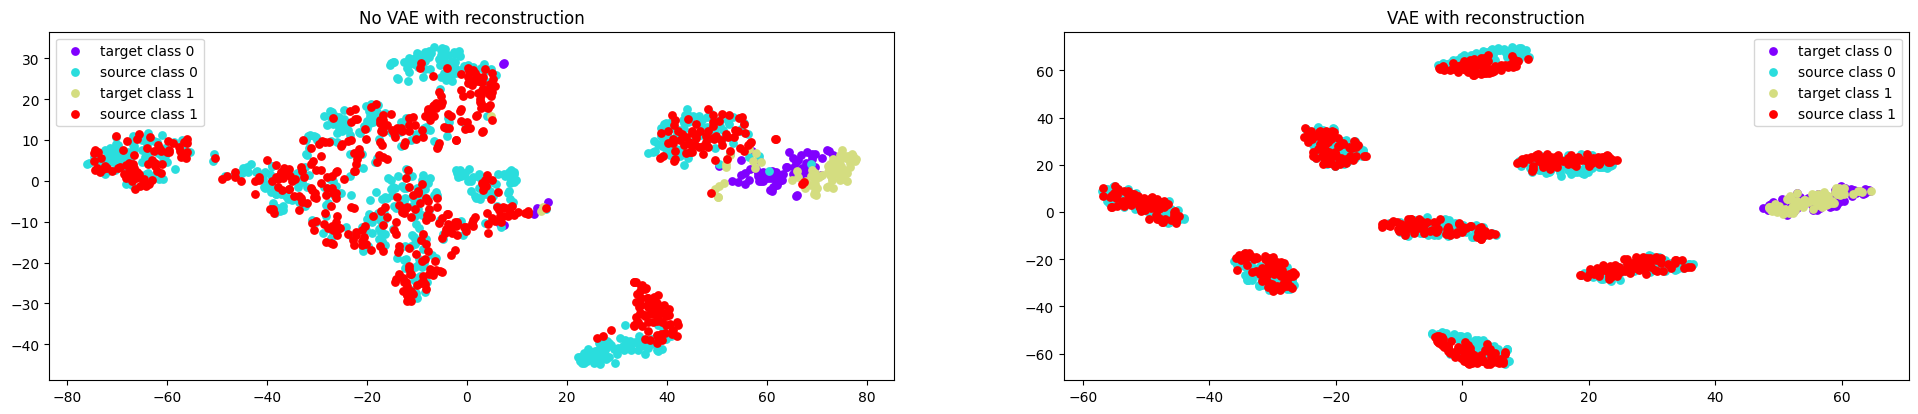

In [31]:
source_and_target_discrimination = np.zeros(y_tl.shape)
for s in range(y_tl.shape[0]):
  source_and_target_discrimination[s] = np.hstack((np.zeros(((ns - 1)*n_trials)), np.ones((n_trials)))).reshape(-1)

discrimination_labels = np.array([0, 1])

tl_plot_BCIIV2a('VAE with reconstruction', t_sne, t_sne_vae_aligned_reconstruction, source_and_target_discrimination, discrimination_labels, ns, n_trials, 
                separate_source_and_target = False, 
                savepath = '/content/drive/MyDrive/EEG TL/figs/VAE with reconstruction src vs tgt')



classes = np.unique(labels)
tl_plot_BCIIV2a('VAE with reconstruction', t_sne, t_sne_vae_aligned_reconstruction, y_tl, classes, ns, n_trials
                ,savepath = '/content/drive/MyDrive/EEG TL/figs/VAE with reconstruction src vs tgt class')

### CSP features EA + VAE with reconstruction

In [81]:
from mne.decoding import CSP

components = 6

csp_features_EA_vae_aligned_reconstruction = np.zeros((ns, n_trials*ns, components))
subjects = np.arange(ns)
y_tl = np.zeros((ns, n_trials*ns))


# The last 144 trials belong to the target subject

for i in range(ns):

  x_src_aligned = np.reshape(vae_aligned_reconstruction_data_EA[subjects != i, :, :], (n_trials*(ns-1), n_channels , n_samples))
  x_tgt_aligned = np.reshape(vae_aligned_reconstruction_data_EA[subjects == i, :, :], (n_trials, n_channels , n_samples))

  y_src = np.reshape(labels[subjects != i], (n_trials*(ns-1)))
  y_tgt = np.reshape(labels[subjects == i], (n_trials))

  csp = CSP(n_components = components, log = None, norm_trace = True)

  x_src_aligned = csp.fit_transform(x_src_aligned, y_src)
  x_tgt_aligned = csp.transform(x_tgt_aligned)

  csp_features_EA_vae_aligned_reconstruction[i, :, :] = np.vstack((x_src_aligned, x_tgt_aligned))
  y_tl[i,:] = np.hstack((y_src, y_tgt)).reshape((-1))



Computing rank from data with rank=None

    Using tolerance 2.8 (2.2e-16 eps * 22 dim * 5.8e+14  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 2.7 (2.2e-16 eps * 22 dim * 5.6e+14  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 7 (2.2e-16 eps * 22 dim * 1.4e+15  max singular value)

    Estimated rank (mag): 22

    MAG: rank 22 computed from 22 data channels with 0 projectors

Reducing data rank from 22 -> 22

Estimating covariance using EMPIRICAL

Done.

Computing rank from data with rank=None

    Using tolerance 7 (2.2e-16 eps * 22 dim * 1.4e+15  max singular value

### Training (no reconstruction)

In [70]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor



batch_size = 48
vae_aligned_no_reconstruction_data = np.zeros(data.shape)
vae = VariationalAutoencoder(n_channels, n_channels).to(device) # GPU

for s in range(ns):
  data_vae = TensorDataset(Tensor(data[s]).to(device), Tensor(labels[s]).to(device))
  dataloader = torch.utils.data.DataLoader(data_vae,
          batch_size=batch_size,
          shuffle=True)

  # vae = VariationalAutoencoder(n_channels, n_channels).to(device) # GPU
  vae = train(vae, dataloader, epochs = 50, reconstruction_loss = False)

  vae_aligned_no_reconstruction_data[s] = vae.decoder(Tensor(data[s]).to(device)).cpu().detach().numpy()

epoch: 49, training loss: 274518.4375

epoch: 49, training loss: 274508.96875

epoch: 49, training loss: 274511.21875

epoch: 49, training loss: 274503.28125

epoch: 49, training loss: 274493.5

epoch: 49, training loss: 274507.34375

epoch: 49, training loss: 274493.3125

epoch: 49, training loss: 274495.125

epoch: 49, training loss: 274493.5625


### CSP feature extraction VAE no reconstruction

In [ ]:
from mne.decoding import CSP

components = 6

csp_features_vae_aligned_no_reconstruction = np.zeros((ns, n_trials*ns, components))
subjects = np.arange(ns)
y_tl = np.zeros((ns, n_trials*ns))


# The last 144 trials belong to the target subject

for i in range(ns):

  x_src_aligned = np.reshape(vae_aligned_reconstruction_data[subjects != i, :, :], (n_trials*(ns-1), n_channels , n_samples))
  x_tgt_aligned = np.reshape(vae_aligned_reconstruction_data[subjects == i, :, :], (n_trials, n_channels , n_samples))

  y_src = np.reshape(labels[subjects != i], (n_trials*(ns-1)))
  y_tgt = np.reshape(labels[subjects == i], (n_trials))

  csp = CSP(n_components = components, log = None, norm_trace = True)

  x_src_aligned = csp.fit_transform(x_src_aligned, y_src)
  x_tgt_aligned = csp.transform(x_tgt_aligned)

  csp_features_vae_aligned_no_reconstruction[i, :, :] = np.vstack((x_src_aligned, x_tgt_aligned))
  y_tl[i,:] = np.hstack((y_src, y_tgt)).reshape((-1))



### VAE with reconstruction on CSP data

In [105]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor



batch_size = 48
vae_aligned_reconstruction_csp = np.zeros(csp_features[0].shape)
vae = VariationalAutoencoder(components, components, permute=False).to(device) # GPU

for s in range(ns):
  data_vae = TensorDataset(Tensor(csp_features[0][s*n_trials:(s+1)*n_trials]).to(device), 
                           Tensor(y_tl[0][s*n_trials:(s+1)*n_trials]).to(device))
  dataloader = torch.utils.data.DataLoader(data_vae,
          batch_size=batch_size,
          shuffle=True)

  vae = train(vae, dataloader, epochs = 30, reconstruction_loss_factor = 5, permute = False)

  vae_aligned_reconstruction_csp[s*n_trials:(s+1)*n_trials] = vae.decoder(Tensor(csp_features[0][s*n_trials:(s+1)*n_trials]).to(
      device)).cpu().detach().numpy()

epoch: 29, training loss: 13998.5791015625

epoch: 29, training loss: 7693.8447265625

epoch: 29, training loss: 3793.4208984375

epoch: 29, training loss: 1858.67529296875

epoch: 29, training loss: 2604.52001953125

epoch: 29, training loss: 1424.8453369140625

epoch: 29, training loss: 2009.6419677734375

epoch: 29, training loss: 1756.003662109375

epoch: 29, training loss: 1190.7193603515625


# Data augmentation approach

## Declaration

In [270]:
class TLDataAugmentation():
  def __init__(self, method = 'mix', mixing_scheme = 'constant', target_mix_strategy = 'random', target_replacement = True):
    self.data_src = None
    self.y_src = None
    self.data_tgt = None
    self.augmented_data = None
    self.y_augmented = None
    self.method = method
    self.mixing_scheme = mixing_scheme
    self.target_mix_strategy = target_mix_strategy
    self.target_replacement = target_replacement

  def augment(self, x_src, y_src, x_tgt, augment_ratio = 0.2, mix_proportion = 0.2):
    self.data_src = x_src
    self.augmented_data = self.data_src
    self.data_tgt = x_tgt
    self.y_src = y_src.reshape(-1, 1)
    self.y_augmented = self.y_src

    n_src_trials = x_src.shape[0]
    n_tgt_trials = x_tgt.shape[0]
    
    from math import ceil
    n_augmented_samples = int(ceil(augment_ratio*n_src_trials))


    step = 1

    #TO DO. Add support for mixing scheme scheduling
    if self.mixing_scheme == 'constant':
      pass

    #sample without replacement from x_src
    src_augmentation_samples = np.random.choice(n_src_trials, n_augmented_samples, replace = False)

    if self.target_mix_strategy == 'random':
      if self.target_replacement:
        tgt_augmentation_samples = np.random.choice(n_tgt_trials, n_augmented_samples, replace = True)

      elif not self.target_replacement and n_augmented_samples < n_tgt_trials:
        tgt_augmentation_samples = np.random.choice(n_tgt_trials, n_augmented_samples, replace = False)

    else:
      print('Not enough target samples!')
      return

    #mix
    if self.method == 'mix':
      for sample in range(n_augmented_samples):
        augmented_sample = (1-mix_proportion*step)*x_src[src_augmentation_samples[sample]] 
        + mix_proportion*step*(x_tgt[tgt_augmentation_samples[sample]])
        
        self.augmented_data = np.vstack((self.augmented_data, augmented_sample))
        
        self.y_augmented = np.vstack((self.y_augmented, y_src[src_augmentation_samples[sample]]))


    elif self.method == 'covmix':
            #sample without replacement from x_src

            #mix with x_tgt
            mixed_data = None
    


  def return_augmented_data(self):
    return self.augmented_data, self.y_augmented
    



## Augment

In [282]:
augmented_csp_data = []
augmented_csp_labels = []
augmented_ea_csp_data = []
augmented_ea_csp_labels = []


augment_ratio = 0.5
mix_proportion = 0.1

for i in range(ns):
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  y_src = y_tl[i, 0:(ns-1)*n_trials]
  
  aug = TLDataAugmentation()
  aug.augment(x_src, y_src, x_tgt, mix_proportion = mix_proportion, augment_ratio = augment_ratio)

  augmented_data_i, augmented_labels_i = aug.return_augmented_data()
  augmented_csp_data.append(augmented_data_i)
  augmented_csp_labels.append(augmented_labels_i)

for i in range(ns):
  x_src = csp_features_aligned[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features_aligned[i, (ns-1)*n_trials:ns*n_trials]
  y_src = y_tl[i, 0:(ns-1)*n_trials]
  
  aug = TLDataAugmentation()
  aug.augment(x_src, y_src, x_tgt, mix_proportion = mix_proportion, augment_ratio = augment_ratio)

  augmented_data_i, augmented_labels_i = aug.return_augmented_data()
  augmented_ea_csp_data.append(augmented_data_i)
  augmented_ea_csp_labels.append(augmented_labels_i)




# Classification

## EA + CSP + LDA

In [144]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()


avg_score = 0
avg_score_EA = 0
subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_src_aligned = csp_features_aligned[i, 0:(ns-1)*n_trials]
  x_tgt_aligned = csp_features_aligned[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_aligned, y_src)
  scores[i][1] = model.score(x_tgt_aligned, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'EA'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/EA_scores')

scores_df

Baseline        EA
average accuracy  0.652778  0.722222
0                 0.687500  0.798611
1                 0.562500  0.597222
2                 0.847222  0.881944
3                 0.555556  0.694444
4                 0.472222  0.604167
5                 0.513889  0.618056
6                 0.555556  0.569444
7                 0.895833  0.861111
8                 0.784722  0.875000

## EA + CSP + EA + LDA

In [145]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()


avg_score = 0
avg_score_EA = 0
subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_src_aligned = csp_features_double_aligned[i, 0:(ns-1)*n_trials]
  x_tgt_aligned = csp_features_double_aligned[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_aligned, y_src)
  scores[i][1] = model.score(x_tgt_aligned, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'Double EA'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/double_EA_scores')

scores_df

Baseline  Double EA
average accuracy  0.652778   0.710648
0                 0.687500   0.763889
1                 0.562500   0.597222
2                 0.847222   0.881944
3                 0.555556   0.687500
4                 0.472222   0.611111
5                 0.513889   0.618056
6                 0.555556   0.583333
7                 0.895833   0.798611
8                 0.784722   0.854167

## CSP + EA + LDA

In [151]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()


avg_score = 0
avg_score_EA = 0
subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_src_aligned = aligned_after_csp[i, 0:(ns-1)*n_trials]
  x_tgt_aligned = aligned_after_csp[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_aligned, y_src)
  scores[i][1] = model.score(x_tgt_aligned, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'EA after CSP'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/EA_after_csp_scores')

scores_df

Baseline  EA after CSP
average accuracy  0.652778      0.690586
0                 0.687500      0.750000
1                 0.562500      0.597222
2                 0.847222      0.819444
3                 0.555556      0.673611
4                 0.472222      0.520833
5                 0.513889      0.625000
6                 0.555556      0.597222
7                 0.895833      0.875000
8                 0.784722      0.756944

## Data augmentation (random sample csp mix)

In [283]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_augmented = augmented_csp_data[i]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_src_augmented = augmented_csp_labels[i]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_augmented, y_src_augmented.ravel())
  scores[i][1] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'CSP Augmentation'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/CSP_augmented')

scores_df

Baseline  CSP Augmentation
average accuracy  0.652778          0.650463
0                 0.687500          0.680556
1                 0.562500          0.555556
2                 0.847222          0.840278
3                 0.555556          0.555556
4                 0.472222          0.472222
5                 0.513889          0.520833
6                 0.555556          0.555556
7                 0.895833          0.895833
8                 0.784722          0.777778

## Data augmentation (random sample ea + csp mix)

In [284]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_augmented = augmented_ea_csp_data[i]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_src_augmented = augmented_ea_csp_labels[i]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_augmented, y_src_augmented.ravel())
  scores[i][1] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'EA CSP Augmentation'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/EA_CSP_augmented')

scores_df

Baseline  EA CSP Augmentation
average accuracy  0.652778             0.531636
0                 0.687500             0.750000
1                 0.562500             0.541667
2                 0.847222             0.500000
3                 0.555556             0.500000
4                 0.472222             0.500000
5                 0.513889             0.493056
6                 0.555556             0.500000
7                 0.895833             0.500000
8                 0.784722             0.500000

## VAE with reconstruction

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_vae_reconstruction = csp_features_vae_aligned_reconstruction[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_tgt_vae_reconstruction = csp_features_vae_aligned_reconstruction[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_vae_reconstruction, y_src)
  scores[i][1] = model.score(x_tgt_vae_reconstruction, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'VAE with Reconstruction'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/VAE_with_reconstruction')

scores_df

Baseline  VAE with Reconstruction
average accuracy  0.652778                 0.637346
0                 0.687500                 0.625000
1                 0.562500                 0.500000
2                 0.847222                 0.826389
3                 0.555556                 0.618056
4                 0.472222                 0.541667
5                 0.513889                 0.506944
6                 0.555556                 0.611111
7                 0.895833                 0.736111
8                 0.784722                 0.770833

## EA + VAE with reconstruction

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_vae_reconstruction = csp_features_EA_vae_aligned_reconstruction[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_tgt_vae_reconstruction = csp_features_EA_vae_aligned_reconstruction[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_vae_reconstruction, y_src)
  scores[i][1] = model.score(x_tgt_vae_reconstruction, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'VAE with Reconstruction'])
# scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/VAE_with_reconstruction')

scores_df

Baseline  VAE with Reconstruction
average accuracy  0.652778                 0.511574
0                 0.687500                 0.500000
1                 0.562500                 0.500000
2                 0.847222                 0.500000
3                 0.555556                 0.500000
4                 0.472222                 0.500000
5                 0.513889                 0.500000
6                 0.555556                 0.500000
7                 0.895833                 0.500000
8                 0.784722                 0.604167

## VAE without reconstruction

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_vae_no_reconstruction = csp_features_vae_aligned_no_reconstruction[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_tgt_vae_no_reconstruction = csp_features_vae_aligned_no_reconstruction[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_vae_no_reconstruction, y_src)
  scores[i][1] = model.score(x_tgt_vae_no_reconstruction, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'VAE without Reconstruction'])
scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/VAE_without_reconstruction')

scores_df

Baseline  VAE without Reconstruction
average accuracy  0.652778                    0.499228
0                 0.687500                    0.500000
1                 0.562500                    0.500000
2                 0.847222                    0.500000
3                 0.555556                    0.500000
4                 0.472222                    0.500000
5                 0.513889                    0.500000
6                 0.555556                    0.493056
7                 0.895833                    0.500000
8                 0.784722                    0.500000

## VAE on CSP with reconstruction error

In [106]:


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from mne.decoding import CSP
from pandas import DataFrame as df

model = LDA()

subjects = np.arange(ns)

components = 6

#first number is for non-aligned data
scores = {'average accuracy': [0,0]}


for i in range(ns):

  scores[i] = [0,0]
  x_src = csp_features[i, 0:(ns-1)*n_trials]
  x_src_vae_reconstruction_csp = vae_aligned_reconstruction_csp[i, 0:(ns-1)*n_trials]
  x_tgt = csp_features[i, (ns-1)*n_trials:ns*n_trials]
  x_tgt_vae_reconstruction_csp = vae_aligned_reconstruction_csp[i, (ns-1)*n_trials:ns*n_trials]

  y_src = y_tl[i, 0:(ns-1)*n_trials]
  y_tgt = y_tl[i,(ns-1)*n_trials:ns*n_trials]

  #non-aligned data
  model.fit(x_src, y_src)
  scores[i][0] = model.score(x_tgt, y_tgt)
  scores['average accuracy'][0] += scores[i][0]

  #aligned data
  model.fit(x_src_vae_reconstruction_csp, y_src)
  scores[i][1] = model.score(x_tgt_vae_reconstruction_csp, y_tgt)
  scores['average accuracy'][1] += scores[i][1]

  
scores['average accuracy'][0] /= ns
scores['average accuracy'][1] /= ns



scores_df = df.from_dict(scores, orient = 'index', columns = ['Baseline', 'VAE with Reconstruction on CSP'])
# scores_df.to_csv('/content/drive/MyDrive/EEG TL/results/VAE_without_reconstruction')

scores_df

ValueError: ignored

# Cross-validation for classification with hyperparameters

In [218]:
def cross_validation_tl(model, params, X_train, y, subj_indices, ns, sklearn_model = None, log = False):
  
  best_score = 0
  if model == 'kernel_shrinkage':
    params['best'] = 0
    for l in params['lambda']:
      mean_score = 0
      for s in range(ns):
        x_src = X_train[s, ~subj_indices[s]]
        y_src = y[s, ~subj_indices[s]]
        x_tgt = X_train[s, subj_indices[s]]
        y_tgt = y[s, subj_indices[s]]
        ## fit model and find score

      if (mean_score > best_score):
        best_score = mean_score
        params['best'] = l


  if model == 'args':
    import itertools
    keys, values = zip(*params.items())
    for v in itertools.product(*values):
      experiment = dict(zip(keys, v))
      
      if sklearn_model == 'xgb':
        from xgboost import XGBClassifier as XGB
        model = XGB(**experiment)

      elif sklearn_model == 'svc':
        from sklearn.svm import SVC
        model = SVC(**experiment)

      else:
        pass
        
      mean_score = 0
      for s in range(ns):
        x_src = X_train[s, ~subj_indices[s]]
        y_src = y[s, ~subj_indices[s]]
        x_tgt = X_train[s, subj_indices[s]]
        y_tgt = y[s, subj_indices[s]]

        model.fit(x_src, y_src)
        score = model.score(x_tgt, y_tgt)
        mean_score += score/ns

      if (mean_score > best_score):
        best_score = mean_score
        params['best'] = experiment
     
        if log:
          print('Found new best score: ', mean_score)
          print('Parameters: ', params['best'])
          print()



In [221]:
subj_indices = []
for s in range(ns):
  subj_indices.append(np.hstack((np.zeros(((ns - 1)*n_trials), dtype = bool), np.ones((n_trials), dtype = bool))).reshape(-1))



In [222]:
params = {'C': [0.01, 0.02, 0.03, 0.05 ,0.1, 1, 10, 20, 30]}
cross_validation_tl('args', params, csp_features_aligned, y_tl, subj_indices, ns, 'svc', log = True)


Found new best score:  0.7152777777777777

Parameters:  {'C': 0.01}



Found new best score:  0.7199074074074074

Parameters:  {'C': 0.02}



Found new best score:  0.7222222222222222

Parameters:  {'C': 0.03}




In [226]:
params = {'n_estimators': [10, 15, 25, 50, 100], 'max_depth' : [2,4,8]}
cross_validation_tl('args', params, csp_features_aligned, y_tl, subj_indices, ns, 'xgb', log = True)

Found new best score:  0.6921296296296297

Parameters:  {'n_estimators': 10, 'max_depth': 2}



Found new best score:  0.7052469135802469

Parameters:  {'n_estimators': 10, 'max_depth': 4}



Found new best score:  0.7083333333333335

Parameters:  {'n_estimators': 25, 'max_depth': 4}




# Conformer

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00


## Imports

In [2]:
"""
EEG Conformer 

Convolutional Transformer for EEG decoding

Couple CNN and Transformer in a concise manner with amazing results
"""
# remember to change paths

import argparse
import os
gpus = [0]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
import numpy as np
import math
import glob
import random
import itertools
import datetime
import time
import datetime
import sys
import scipy.io

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
!pip install torchsummary
from torchsummary import summary
import torch.autograd as autograd
from torchvision.models import vgg19

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# from common_spatial_pattern import csp

import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True

# writer = SummaryWriter('./TensorBoardX/')



ModuleNotFoundError: No module named 'einops'

## Architecture Declaration

In [ ]:
# Convolution module
# use conv to capture local features, instead of postion embedding.
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # transpose, conv could enhance fiting ability slightly
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))


class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        # global average pooling
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(1760, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return x, out


class Conformer(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=2, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )



In [ ]:

class ExP():
  def __init__(self, nsub):
      super(ExP, self).__init__()
      self.batch_size = 36
      self.n_epochs = 750
      self.n_classes = 2
      self.n_samples = 750
      self.n_channels = 22
      self.n_trials = 144
      self.lr = 0.0002
      self.b1 = 0.5
      self.b2 = 0.999
      # self.dimension = (190, 50)
      self.nSub = nsub
      self.ns = 9
      self.n_aug_samples = 125 
      self.n_aug_patch = int(self.n_samples/self.n_aug_samples)

      self.start_epoch = 0
      # self.root = '/Data/strict_TE/'

      self.log_write = open("/content/drive/MyDrive/SML Model/log_subject%d.txt" % self.nSub, "w")


      self.Tensor = torch.cuda.FloatTensor
      self.LongTensor = torch.cuda.LongTensor

      self.criterion_l1 = torch.nn.L1Loss().cuda()
      self.criterion_l2 = torch.nn.MSELoss().cuda()
      self.criterion_cls = torch.nn.CrossEntropyLoss().cuda()

      self.model = Conformer().cuda()
      self.model = nn.DataParallel(self.model, device_ids=[i for i in range(len(gpus))])
      self.model = self.model.cuda()
      # summary(self.model, (1, 22, 1000))


  # Segmentation and Reconstruction (S&R) data augmentation
  def interaug(self, timg, label):  
      aug_data = []
      aug_label = []
      for cls4aug in range(self.n_classes):
          cls_idx = np.where(label == cls4aug)
          tmp_data = timg[cls_idx]
          tmp_label = label[cls_idx]

          tmp_aug_data = np.zeros((int(self.batch_size / 4), 1, self.n_channels, 
                                   self.n_samples))
          for ri in range(int(self.batch_size / 4)):
              for rj in range(self.n_aug_patch):
                  rand_idx = np.random.randint(0, tmp_data.shape[0], self.n_aug_samples)
                  tmp_aug_data[ri, :, :, rj * self.n_aug_samples
                               :(rj + 1) * self.n_aug_samples] = tmp_data[
                                  rand_idx[rj], :, :,
                                  rj * self.n_aug_samples:(rj + 1) * self.n_aug_samples]

          aug_data.append(tmp_aug_data)
          aug_label.append(tmp_label[:int(self.batch_size / 4)])
      aug_data = np.concatenate(aug_data)
      aug_label = np.concatenate(aug_label)
      aug_shuffle = np.random.permutation(len(aug_data))
      aug_data = aug_data[aug_shuffle, :, :]
      aug_label = aug_label[aug_shuffle]

      aug_data = torch.from_numpy(aug_data).cuda()
      aug_data = aug_data.float()
      aug_label = torch.from_numpy(aug_label).cuda()
      aug_label = aug_label.long()
      return aug_data, aug_label

  def get_source_data(self):

      # # train data
      # self.total_data = scipy.io.loadmat(self.root + 'A0%dT.mat' % self.nSub)
      # self.train_data = self.total_data['data']
      # self.train_label = self.total_data['label']

      # self.train_data = np.transpose(self.train_data, (2, 1, 0))
      data = np.load('/content/kaggle/working/BCICIV2a/data_not_filtered_EA.npy')
      labels = np.load('/content/kaggle/working/BCICIV2a/labels.npy')
      subjects = np.arange(self.ns)

      self.x_src = np.reshape(data[subjects != i, :, :], (self.n_trials*(self.ns-1), 
                                                     self.n_channels , self.n_samples))
      self.x_tgt = np.reshape(data[subjects == i, :, :], (self.n_trials, 
                                                     self.n_channels , self.n_samples))

      self.y_src = np.reshape(labels[subjects != i], (self.n_trials*(self.ns-1)))
      self.y_tgt = np.reshape(labels[subjects == i], (self.n_trials))
      
      self.x_src = np.expand_dims(self.x_src, axis=1)
      # self.src_label = np.transpose(self.src_label)


      # test data
      # self.test_tmp = scipy.io.loadmat(self.root + 'A0%dE.mat' % self.nSub)
      # self.test_data = self.test_tmp['data']
      # self.test_label = self.test_tmp['label']

      # self.test_data = np.transpose(self.test_data, (2, 1, 0))
      self.x_tgt = np.expand_dims(self.x_tgt, axis=1)
      # self.test_label = np.transpose(self.test_label)

      # self.testData = self.test_data
      # self.testLabel = self.test_label[0]


      # standardize
      # target_mean = np.mean(self.allData)
      # target_std = np.std(self.allData)
      # self.allData = (self.allData - target_mean) / target_std
      # self.testData = (self.testData - target_mean) / target_std

      # data shape: (trial, conv channel, electrode channel, time samples)
      return self.x_src, self.y_src, self.x_tgt, self.y_tgt


  def train(self):

      img, label, test_data, test_label = self.get_source_data()

      img = torch.from_numpy(img)
      label = torch.from_numpy(label)

      dataset = torch.utils.data.TensorDataset(img, label)
      self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

      test_data = torch.from_numpy(test_data)
      test_label = torch.from_numpy(test_label)
      test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
      self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=True)

      # Optimizers
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))

      test_data = Variable(test_data.type(self.Tensor))
      test_label = Variable(test_label.type(self.LongTensor))

      bestAcc = 0
      averAcc = 0
      num = 0
      Y_true = 0
      Y_pred = 0

      # Train the cnn model
      total_step = len(self.dataloader)
      curr_lr = self.lr

      # test_np = test_data.cpu().numpy()
      # ea = EA()
      # ea.fit(np.squeeze(test_np))
      # test_np = ea.predict(np.squeeze(test_np))
      # test_np = np.expand_dims(test_np, axis=1)
      # test_data = torch.from_numpy(test_np).cuda().type(self.Tensor)

      for e in range(self.n_epochs):
          # in_epoch = time.time()
          self.model.train()
          for i, (img, label) in enumerate(self.dataloader):

              img = Variable(img.cuda().type(self.Tensor))
              label = Variable(label.cuda().type(self.LongTensor))

              # data augmentation
              aug_data, aug_label = self.interaug(self.x_src, self.y_src)
              img = torch.cat((img, aug_data))
              label = torch.cat((label, aug_label))

              # ea = EA()
              # img_np = img.cpu().numpy()
              # ea.fit(np.squeeze(img_np))
              # img_np = ea.predict(np.squeeze(img_np))
              # img_np = np.expand_dims(img_np, axis=1)
              # img = torch.from_numpy(img).cuda().type(self.Tensor)

              tok, outputs = self.model(img)

              loss = self.criterion_cls(outputs, label) 

              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()


          # out_epoch = time.time()


          # test process
          if (e + 1) % 20 == 0:
              self.model.eval()


              Tok, Cls = self.model(test_data)


              loss_test = self.criterion_cls(Cls, test_label)
              y_pred = torch.max(Cls, 1)[1]
              acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
              train_pred = torch.max(outputs, 1)[1]
              train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))

              print('Epoch:', e,
                    '  Train loss: %.6f' % loss.detach().cpu().numpy(),
                    '  Test loss: %.6f' % loss_test.detach().cpu().numpy(),
                    '  Train accuracy %.6f' % train_acc,
                    '  Test accuracy is %.6f' % acc)

              self.log_write.write(str(e) + "    " + str(acc) + "\n")
              num = num + 1
              averAcc = averAcc + acc
              if acc > bestAcc:
                  bestAcc = acc
                  Y_true = test_label
                  Y_pred = y_pred


      torch.save(self.model.module.state_dict(), 'model.pth')
      averAcc = averAcc / num
      print('The average accuracy is:', averAcc)
      print('The best accuracy is:', bestAcc)
      self.log_write.write('The average accuracy is: ' + str(averAcc) + "\n")
      self.log_write.write('The best accuracy is: ' + str(bestAcc) + "\n")

      return bestAcc, averAcc, Y_true, Y_pred
      # writer.close()


## Experiment

In [ ]:


print(time.asctime(time.localtime(time.time())))

best = 0
aver = 0
result_write = open("/content/drive/MyDrive/SML Model/sub_result.txt", "w")
ns = 9

for i in range(ns):
  starttime = datetime.datetime.now()


  seed_n = np.random.randint(2023)
  print('seed is ' + str(seed_n))
  random.seed(seed_n)
  np.random.seed(seed_n)
  torch.manual_seed(seed_n)
  torch.cuda.manual_seed(seed_n)
  torch.cuda.manual_seed_all(seed_n)


  print('Subject %d' % (i+1))
  exp = ExP(i)

  bestAcc, averAcc, Y_true, Y_pred = exp.train()
  print('THE BEST ACCURACY IS ' + str(bestAcc))
  result_write.write('Subject ' + str(i + 1) + ' : ' + 'Seed is: ' + str(seed_n) + "\n")
  result_write.write('Subject ' + str(i + 1) + ' : ' + 'The best accuracy is: ' + str(bestAcc) + "\n")
  result_write.write('Subject ' + str(i + 1) + ' : ' + 'The average accuracy is: ' + str(averAcc) + "\n")

  endtime = datetime.datetime.now()
  print('subject %d duration: '%(i+1) + str(endtime - starttime))
  best = best + bestAcc
  aver = aver + averAcc
  # if i == 0:
  #     yt = Y_true
  #     yp = Y_pred
  # else:
  #     yt = torch.cat((yt, Y_true))
  #     yp = torch.cat((yp, Y_pred))


best = best / ns
aver = aver / ns

result_write.write('**The average Best accuracy is: ' + str(best) + "\n")
result_write.write('The average Aver accuracy is: ' + str(aver) + "\n")
result_write.close()


print(time.asctime(time.localtime(time.time())))

# EEG-TCNet

## Architecture

In [18]:
#*----------------------------------------------------------------------------*
#* Copyright (C) 2020 ETH Zurich, Switzerland                                 *
#* SPDX-License-Identifier: Apache-2.0                                        *
#*                                                                            *
#* Licensed under the Apache License, Version 2.0 (the "License");            *
#* you may not use this file except in compliance with the License.           *
#* You may obtain a copy of the License at                                    *
#*                                                                            *
#* http://www.apache.org/licenses/LICENSE-2.0                                 *
#*                                                                            *
#* Unless required by applicable law or agreed to in writing, software        *
#* distributed under the License is distributed on an "AS IS" BASIS,          *
#* WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.   *
#* See the License for the specific language governing permissions and        *
#* limitations under the License.                                             *
#*                                                                            *
#* Author:  Thorir Mar Ingolfsson                                             *
#*----------------------------------------------------------------------------*

#!/usr/bin/env python3

from keras.models import Model
from keras.layers.core import Dense, Activation
from keras.layers.convolutional import Conv1D,Conv2D, AveragePooling2D,SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dropout, Add, Lambda,DepthwiseConv2D,Input, Permute
from tensorflow.keras.constraints import max_norm


def EEGTCNet(nb_classes,Chans=64, Samples=128, layers=3, kernel_s=10,filt=10, dropout=0, activation='relu', F1=4, D=2, kernLength=64, dropout_eeg=0.1):
    input1 = Input(shape = (1,Chans, Samples))
    input2 = Permute((3,2,1))(input1)
    regRate=.25
    numFilters = F1
    F2= numFilters*D

    EEGNet_sep = EEGNet(input_layer=input2,F1=F1,kernLength=kernLength,D=D,Chans=Chans,dropout=dropout_eeg)
    block2 = Lambda(lambda x: x[:,:,-1,:])(EEGNet_sep)
    outs = TCN_block(input_layer=block2,input_dimension=F2,depth=layers,kernel_size=kernel_s,filters=filt,dropout=dropout,activation=activation)
    out = Lambda(lambda x: x[:,-1,:])(outs)
    dense        = Dense(nb_classes, name = 'dense',kernel_constraint = max_norm(regRate))(out)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1,outputs=softmax)

def EEGNet(input_layer,F1=4,kernLength=64,D=2,Chans=22,dropout=0.1):
    F2= F1*D
    block1 = Conv2D(F1, (kernLength, 1), padding = 'same',data_format='channels_last',use_bias = False)(input_layer)
    block1 = BatchNormalization(axis = -1)(block1)
    block2 = DepthwiseConv2D((1, Chans), use_bias = False, 
                                    depth_multiplier = D,
                                    data_format='channels_last',
                                    depthwise_constraint = max_norm(1.))(block1)
    block2 = BatchNormalization(axis = -1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8,1),data_format='channels_last')(block2)
    block2 = Dropout(dropout)(block2)
    block3 = SeparableConv2D(F2, (16, 1),
                            data_format='channels_last',
                            use_bias = False, padding = 'same')(block2)
    block3 = BatchNormalization(axis = -1)(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((8,1),data_format='channels_last')(block3)
    block3 = Dropout(dropout)(block3)
    return block3

def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='relu'):
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out

## Imports

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import numpy as np

## Training

In [36]:
import numpy as np
import scipy.io as sio
import glob as glob
from tensorflow.keras.utils import to_categorical

def prepare_features(current_subject, ns, n_trials, n_samples):

    data = np.load('/kaggle/working/BCICIV2a/data_not_filtered.npy')
    labels = np.load('/kaggle/working/BCICIV2a/labels.npy')
    subjects = np.arange(ns)

    x_src = np.reshape(data[subjects != current_subject, :, :], (n_trials*(ns-1), 
                                                 n_channels , n_samples))
    x_tgt = np.reshape(data[subjects == current_subject, :, :], (n_trials, 
                                                 n_channels , n_samples))

    x_src = np.expand_dims(x_src, axis=1)
    x_tgt = np.expand_dims(x_tgt, axis=1)

    y_src = np.reshape(labels[subjects != current_subject], (n_trials*(ns-1)))
    y_tgt = np.reshape(labels[subjects == current_subject], (n_trials))

    # prepare training data 	
    y_src_onehot = (y_src).astype(int)
    y_src_onehot = to_categorical(y_src_onehot)
    
    # prepare testing data 
    y_tgt_onehot = (y_tgt).astype(int)
    y_tgt_onehot = to_categorical(y_tgt_onehot)	

    return x_src,y_src,y_src_onehot,x_tgt,y_tgt,y_tgt_onehot

In [43]:
F1 = 8
KE = 32
KT = 4
L = 2
FT = 12
pe = 0.2
pt = 0.3
classes = 2
channels = 22
crossValidation = False
batch_size = 36
epochs = 600
lr = 0.001
ns = 9
n_trials = 144
n_samples = 750

for subject in range(ns):

    X_train,y_train,y_train_onehot,X_test,y_test,y_test_onehot = prepare_features(subject, ns, n_trials, n_samples)
    model = EEGTCNet(nb_classes = 2, Chans=22, Samples=750, layers=L, kernel_s=KT,filt=FT, 
                     dropout=pt, activation='elu', F1=F1, D=2, kernLength=KE, dropout_eeg=pe)
    opt = Adam(lr=lr)
    model.compile(loss=categorical_crossentropy,optimizer=opt, metrics=['accuracy'])
    for j in range(channels):
        scaler = StandardScaler()
        scaler.fit(X_train[:,0,j,:])
        X_train[:,0,j,:] = scaler.transform(X_train[:,0,j,:])
        X_test[:,0,j,:] = scaler.transform(X_test[:,0,j,:])
        
    model.fit(X_train, y_train_onehot,batch_size=batch_size, epochs=750, verbose=1)
    y_pred = model.predict(X_test).argmax(axis=-1)
    labels = y_test_onehot.argmax(axis=-1)
    accuracy_of_test = accuracy_score(labels, y_pred)
    print(accuracy_of_test)

32/32 [==============================] - 0s 15ms/step - loss: 0.0895 - accuracy: 0.9679
Epoch 340/750
32/32 [==============================] - 0s 15ms/step - loss: 0.1176 - accuracy: 0.9514
Epoch 341/750
32/32 [==============================] - 1s 16ms/step - loss: 0.1045 - accuracy: 0.9601
Epoch 342/750
32/32 [==============================] - 1s 16ms/step - loss: 0.1077 - accuracy: 0.9601
Epoch 343/750
32/32 [==============================] - 0s 15ms/step - loss: 0.0996 - accuracy: 0.9618
Epoch 344/750
32/32 [==============================] - 0s 15ms/step - loss: 0.0932 - accuracy: 0.9731
Epoch 345/750
32/32 [==============================] - 0s 15ms/step - loss: 0.1046 - accuracy: 0.9601
Epoch 346/750
32/32 [==============================] - 0s 15ms/step - loss: 0.1212 - accuracy: 0.9514
Epoch 347/750
32/32 [==============================] - 0s 15ms/step - loss: 0.1150 - accuracy: 0.9575
Epoch 348/750
32/32 [==============================] - 0s 15ms/step - loss: 0.0945 - accuracy: 0

2023-05-29 14:36:40.005087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_192/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 57s 16ms/step - loss: 0.7135 - accuracy: 0.5234
Epoch 2/750
32/32 [==============================] - 0s 15ms/step - loss: 0.6904 - accuracy: 0.5417
Epoch 3/750
32/32 [==============================] - 0s 15ms/step - loss: 0.6682 - accuracy: 0.5903
Epoch 4/750
32/32 [==============================] - 0s 15ms/step - loss: 0.6507 - accuracy: 0.6111
Epoch 5/750
32/32 [==============================] - 0s 15ms/step - loss: 0.6166 - accuracy: 0.6536
Epoch 6/750
32/32 [==============================] - 0s 15ms/step - loss: 0.6061 - accuracy: 0.6736
Epoch 7/750
32/32 [==============================] - 0s 15ms/step - loss: 0.5863 - accuracy: 0.6979
Epoch 8/750
32/32 [==============================] - 0s 15ms/step - loss: 0.5919 - accuracy: 0.6918
Epoch 9/750
32/32 [==============================] - 0s 15ms/step - loss: 0.5673 - accuracy: 0.7153
Epoch 10/750
32/32 [==============================] - 1s 17ms/step - loss: 0.5588 - accuracy: 0.7040
Epoch 11/7